In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Analysis of peaked background
In this notebook, the peaked background is analysed.
It is assumed that we already know how to select it, using the cuts determined in `study_peaked.ipynb`

## Libraries

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from numba import jit

from lib import plot as lp, data, clustering

from project import defs, files, col
from project.defs import dict_color_clu_labels

import notebook_fcts
from notebook_fcts import (
    select_new_predominant_channelId,
    get_channel_id_counts
)



## Load dataframe

In [3]:
list_voi = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean',
]

columns = [
    'max_m_mean',
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
    'mean_rounded',
    "max_m_mean_rounded",
    'max_m_min',    
    "std_d_max_m_min",
    "std_without_neg_peaks_d_max_m_min",
    "std_without_pos_peaks_d_max_m_min",
    "relative_mean",
    "std_period_d_mean_period"
]

other_columns = [
    "nb_peaks_sup_80_wrt_min",
    "best_chi2"
]

other_columns += [
    "nb_pos_peaks",
    "nb_neg_peaks"
]

other_columns += [
    "std_without_pos_peaks",
    "std_without_neg_peaks"
]

other_columns += [
    "mean_period_max",
    "mean_period_min",
    "mean_period",
    "std_period_max",
    "std_period_min",
    "std_period"
]

other_columns += [
    "mean2_diff_max",
    "mean2_diff_min",
    "mean2_diff"
]


# layer = None

config_name = f"run1_pos_peak"
file_path = files.get_path_processed_root(config_name)
loaded_dataframe, column_labels = files.load_and_process_dataframe(
    file_path, list_voi, columns, other_columns,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector", "channelId", "IEvent", "layer"],
    verbose=True,
    # cut=f"layer=={layer}" if layer is not None else None
)

layers = [0, 1, 2, 3]

dataframes = {}
for layer in layers:
    dataframes[layer] = loaded_dataframe.query(f"layer == {layer}")

Time taken to load the ROOT files: 4.306621074676514
ROOT files loaded: /mnt/e/900GeV/processed/simulation/run1_pos_peak.root
COMPUTE VOIs
Time taken to compute the voi: 0.10873126983642578
Remove events with std == 0
COMPUTE COLUMNS (not already computed)


In [4]:
config_name_ref = "run1_small"
ref_file_path = files.get_path_processed_root(config_name_ref)

ref_dataframe, _ = files.load_and_process_dataframe(
    ref_file_path,
    branches=defs.list_samples_columns+["eta", "phi", "region", "detector", "channelId", "IEvent", "layer"],
    verbose=True,
    # cut=f"layer=={layer}" if layer is not None else None
)

print("\# of events:", len(ref_dataframe))

Time taken to load the ROOT files: 7.212453126907349
ROOT files loaded: /mnt/e/900GeV/processed/simulation/run1_small.root
COMPUTE VOIs
Time taken to compute the voi: 0.1773374080657959
Remove events with std == 0
COMPUTE COLUMNS (not already computed)
\# of events: 653642


In [8]:
plot_hist_each_layer = partial(
    notebook_fcts.plot_hist_each_layer,
    column_labels=column_labels
)

In [9]:
for layer, dataframe in dataframes.items():
    print("Layer", layer, "-"*10)
    print("# of events in total:", len(dataframe))


Layer 0 ----------
# of events in total: 25515
Layer 1 ----------
# of events in total: 27961
Layer 2 ----------
# of events in total: 35098
Layer 3 ----------
# of events in total: 9420


### Amplitude and number of peaks

(<Figure size 2304x432 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Layer 0'}, xlabel='$\\# \\text{ up peaks}$', ylabel='$\\max{e} - \\min{e}$'>,
        <AxesSubplot:title={'center':'Layer 1'}, xlabel='$\\# \\text{ up peaks}$', ylabel='$\\max{e} - \\min{e}$'>,
        <AxesSubplot:title={'center':'Layer 2'}, xlabel='$\\# \\text{ up peaks}$', ylabel='$\\max{e} - \\min{e}$'>,
        <AxesSubplot:title={'center':'Layer 3'}, xlabel='$\\# \\text{ up peaks}$', ylabel='$\\max{e} - \\min{e}$'>],
       dtype=object))

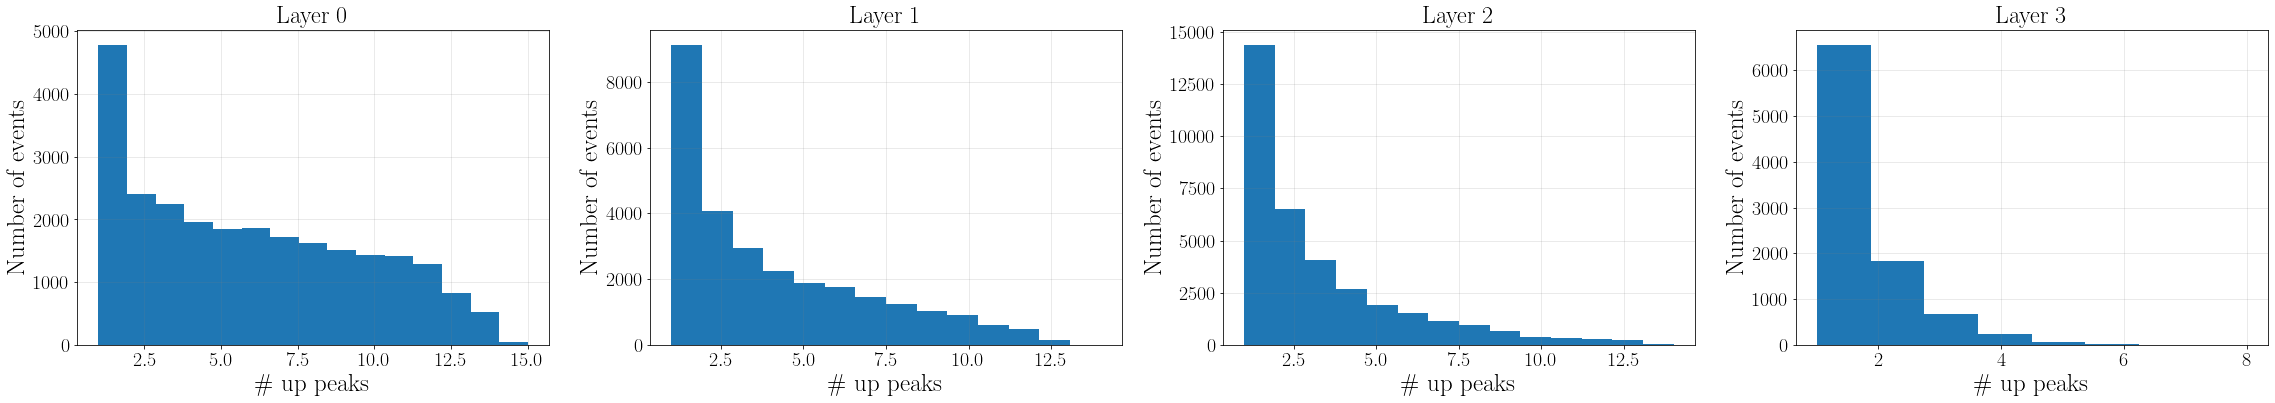

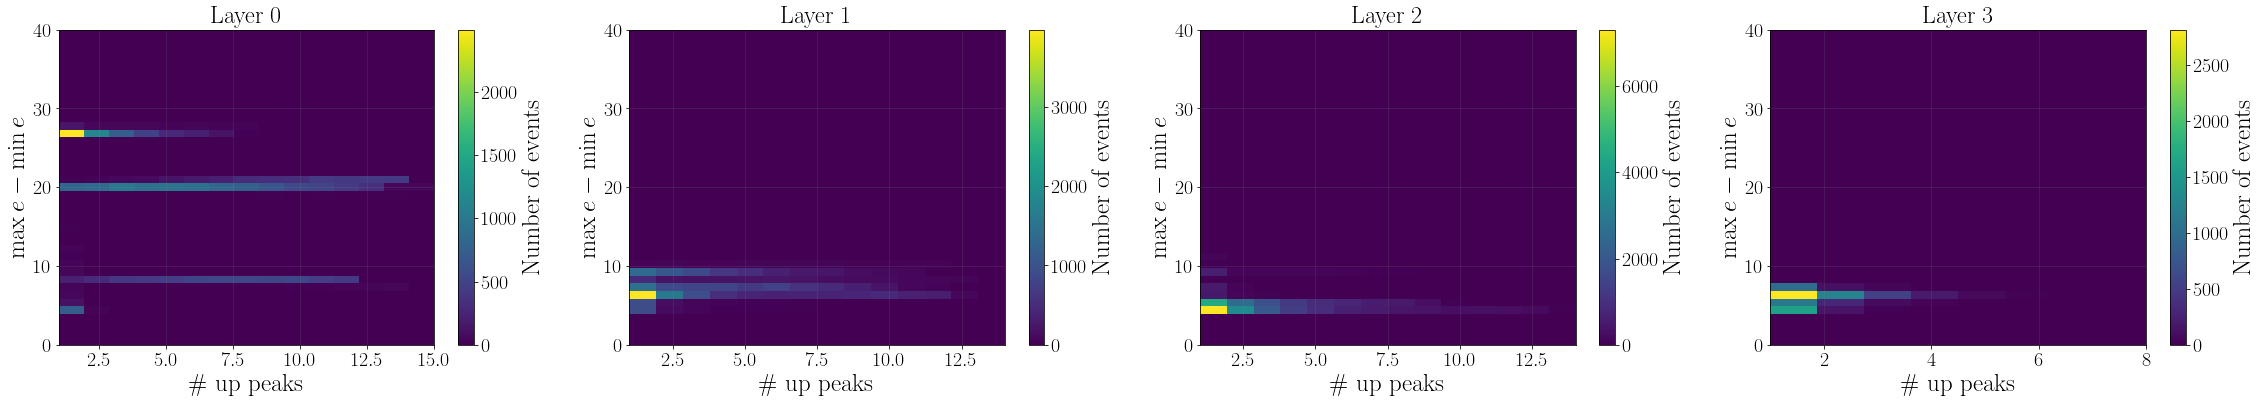

In [11]:
plot_hist_each_layer(
    dataframes,
    "nb_pos_peaks",
    bins="discretised"
)

plot_hist_each_layer(
    dataframes,
    "nb_pos_peaks", "max_m_min",
    bins="discretised",
    min_max=(None,(0, 40))
)

Layer 0 ----------


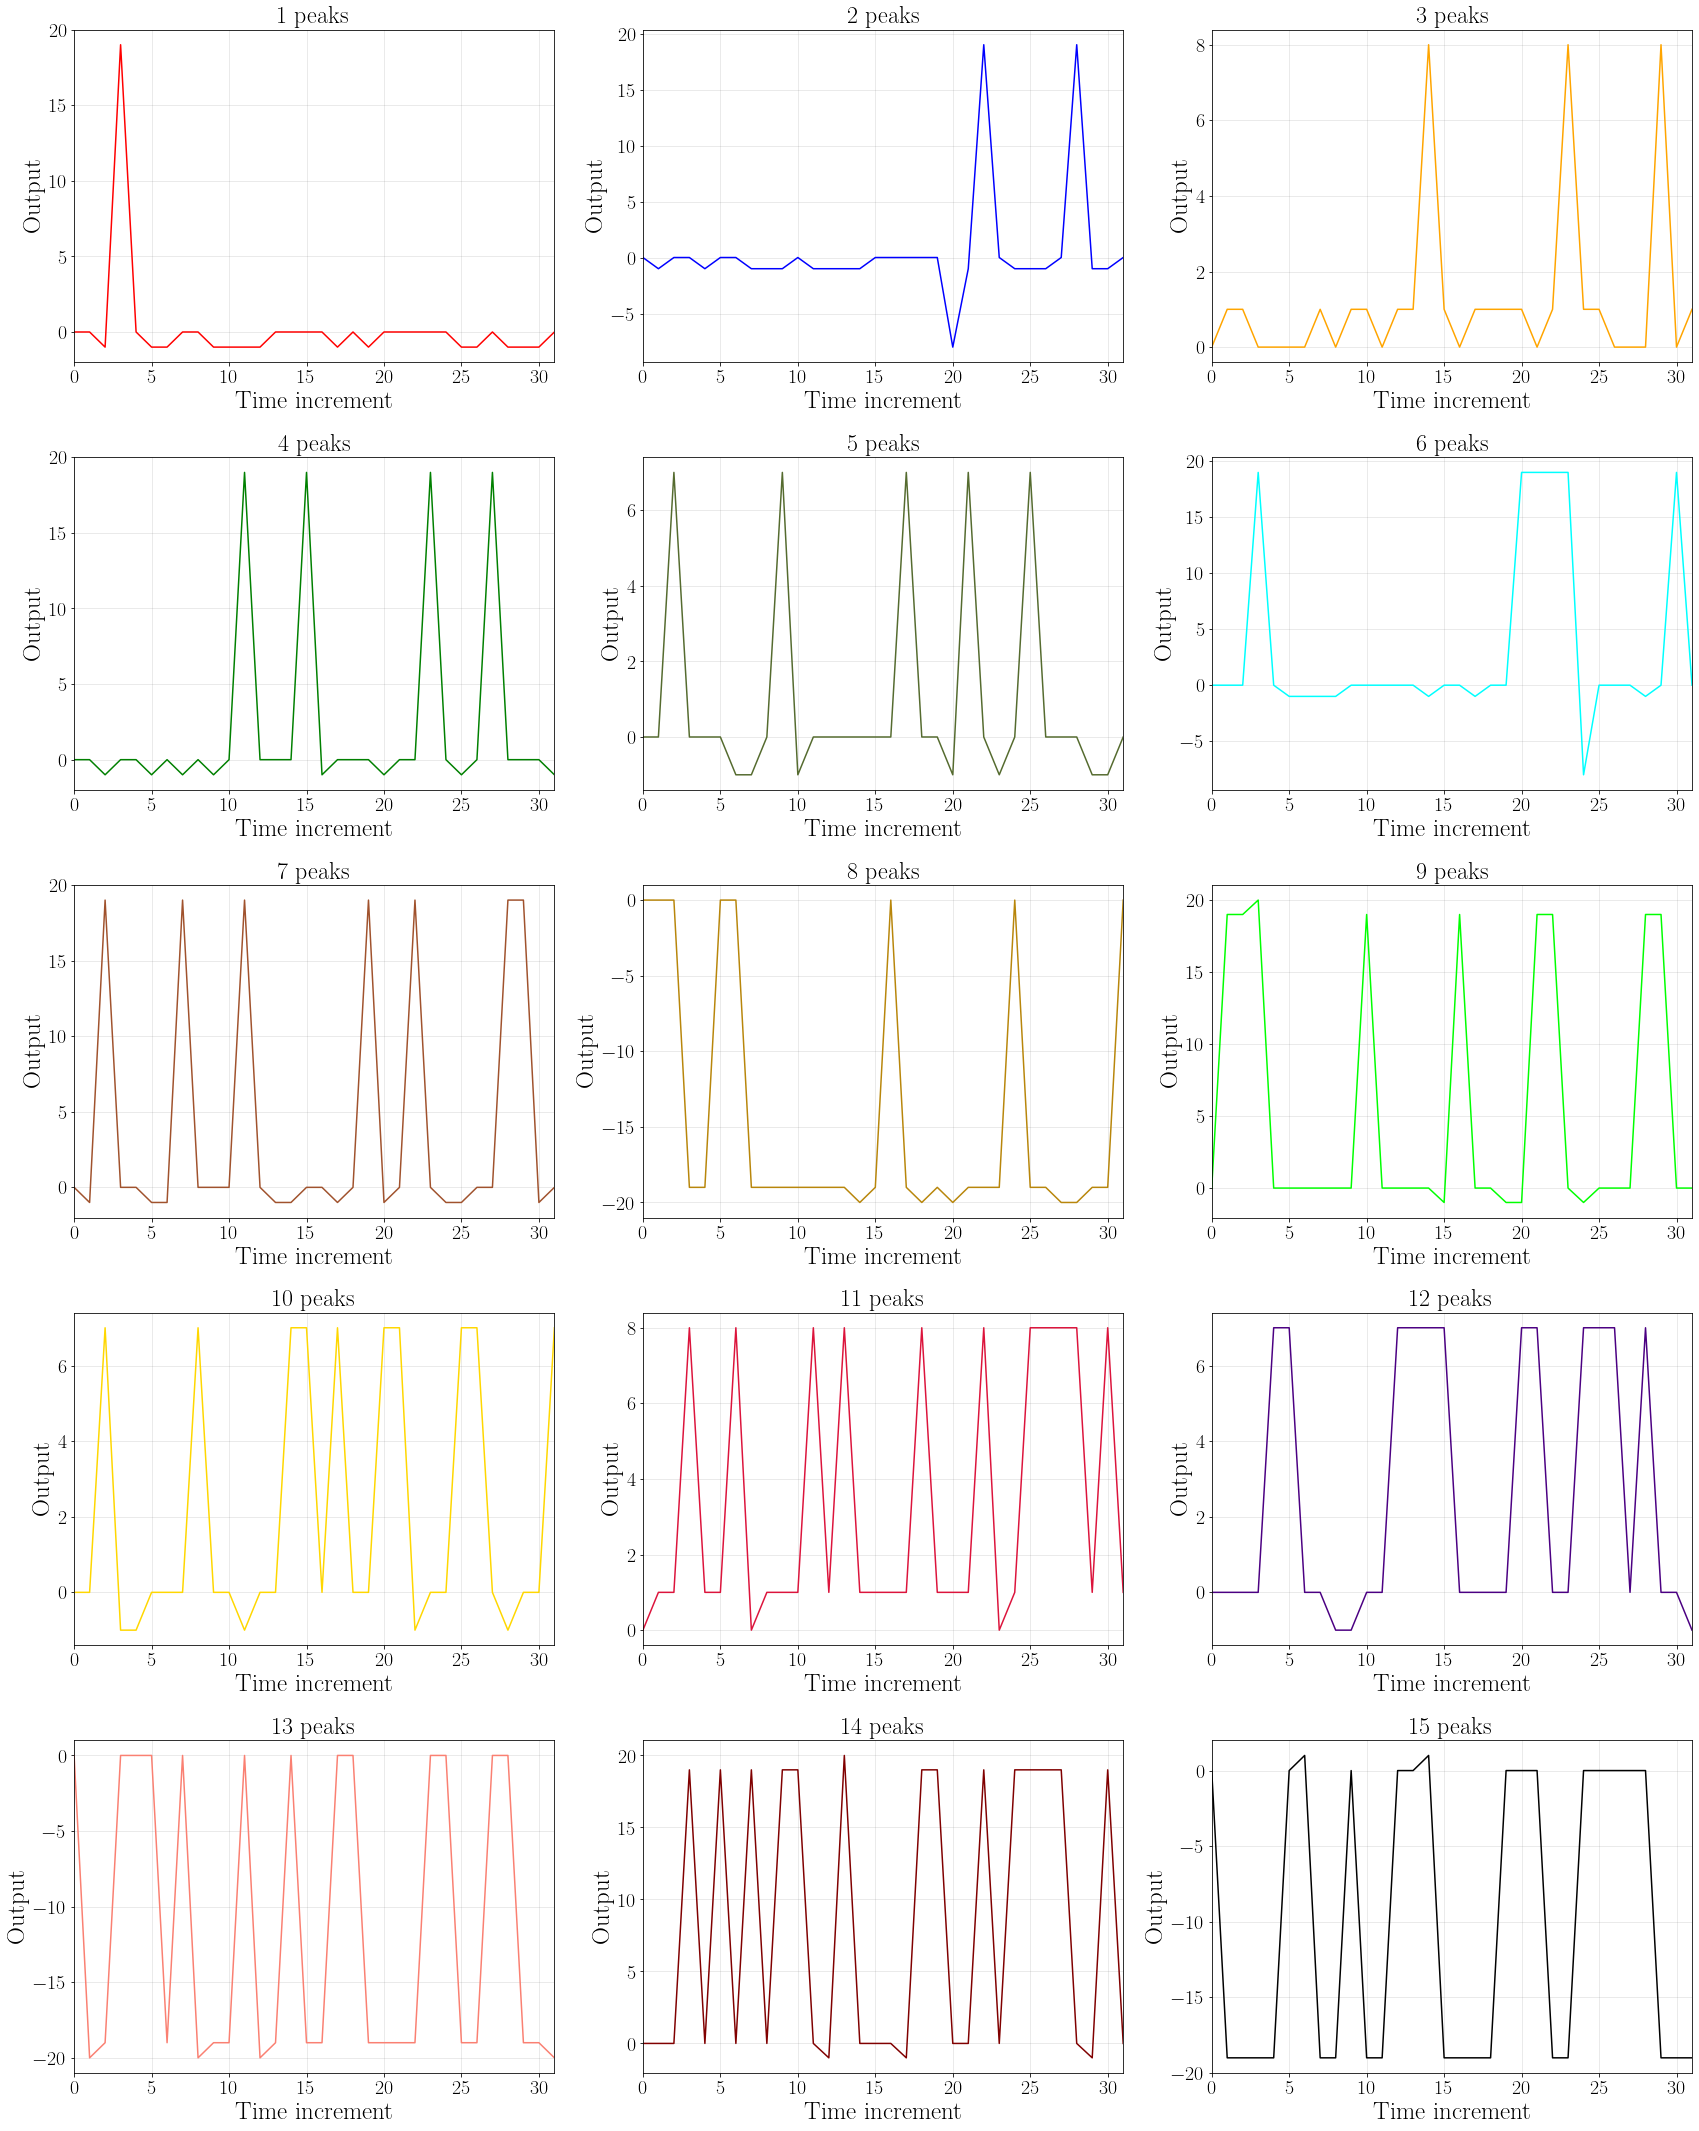

Layer 1 ----------


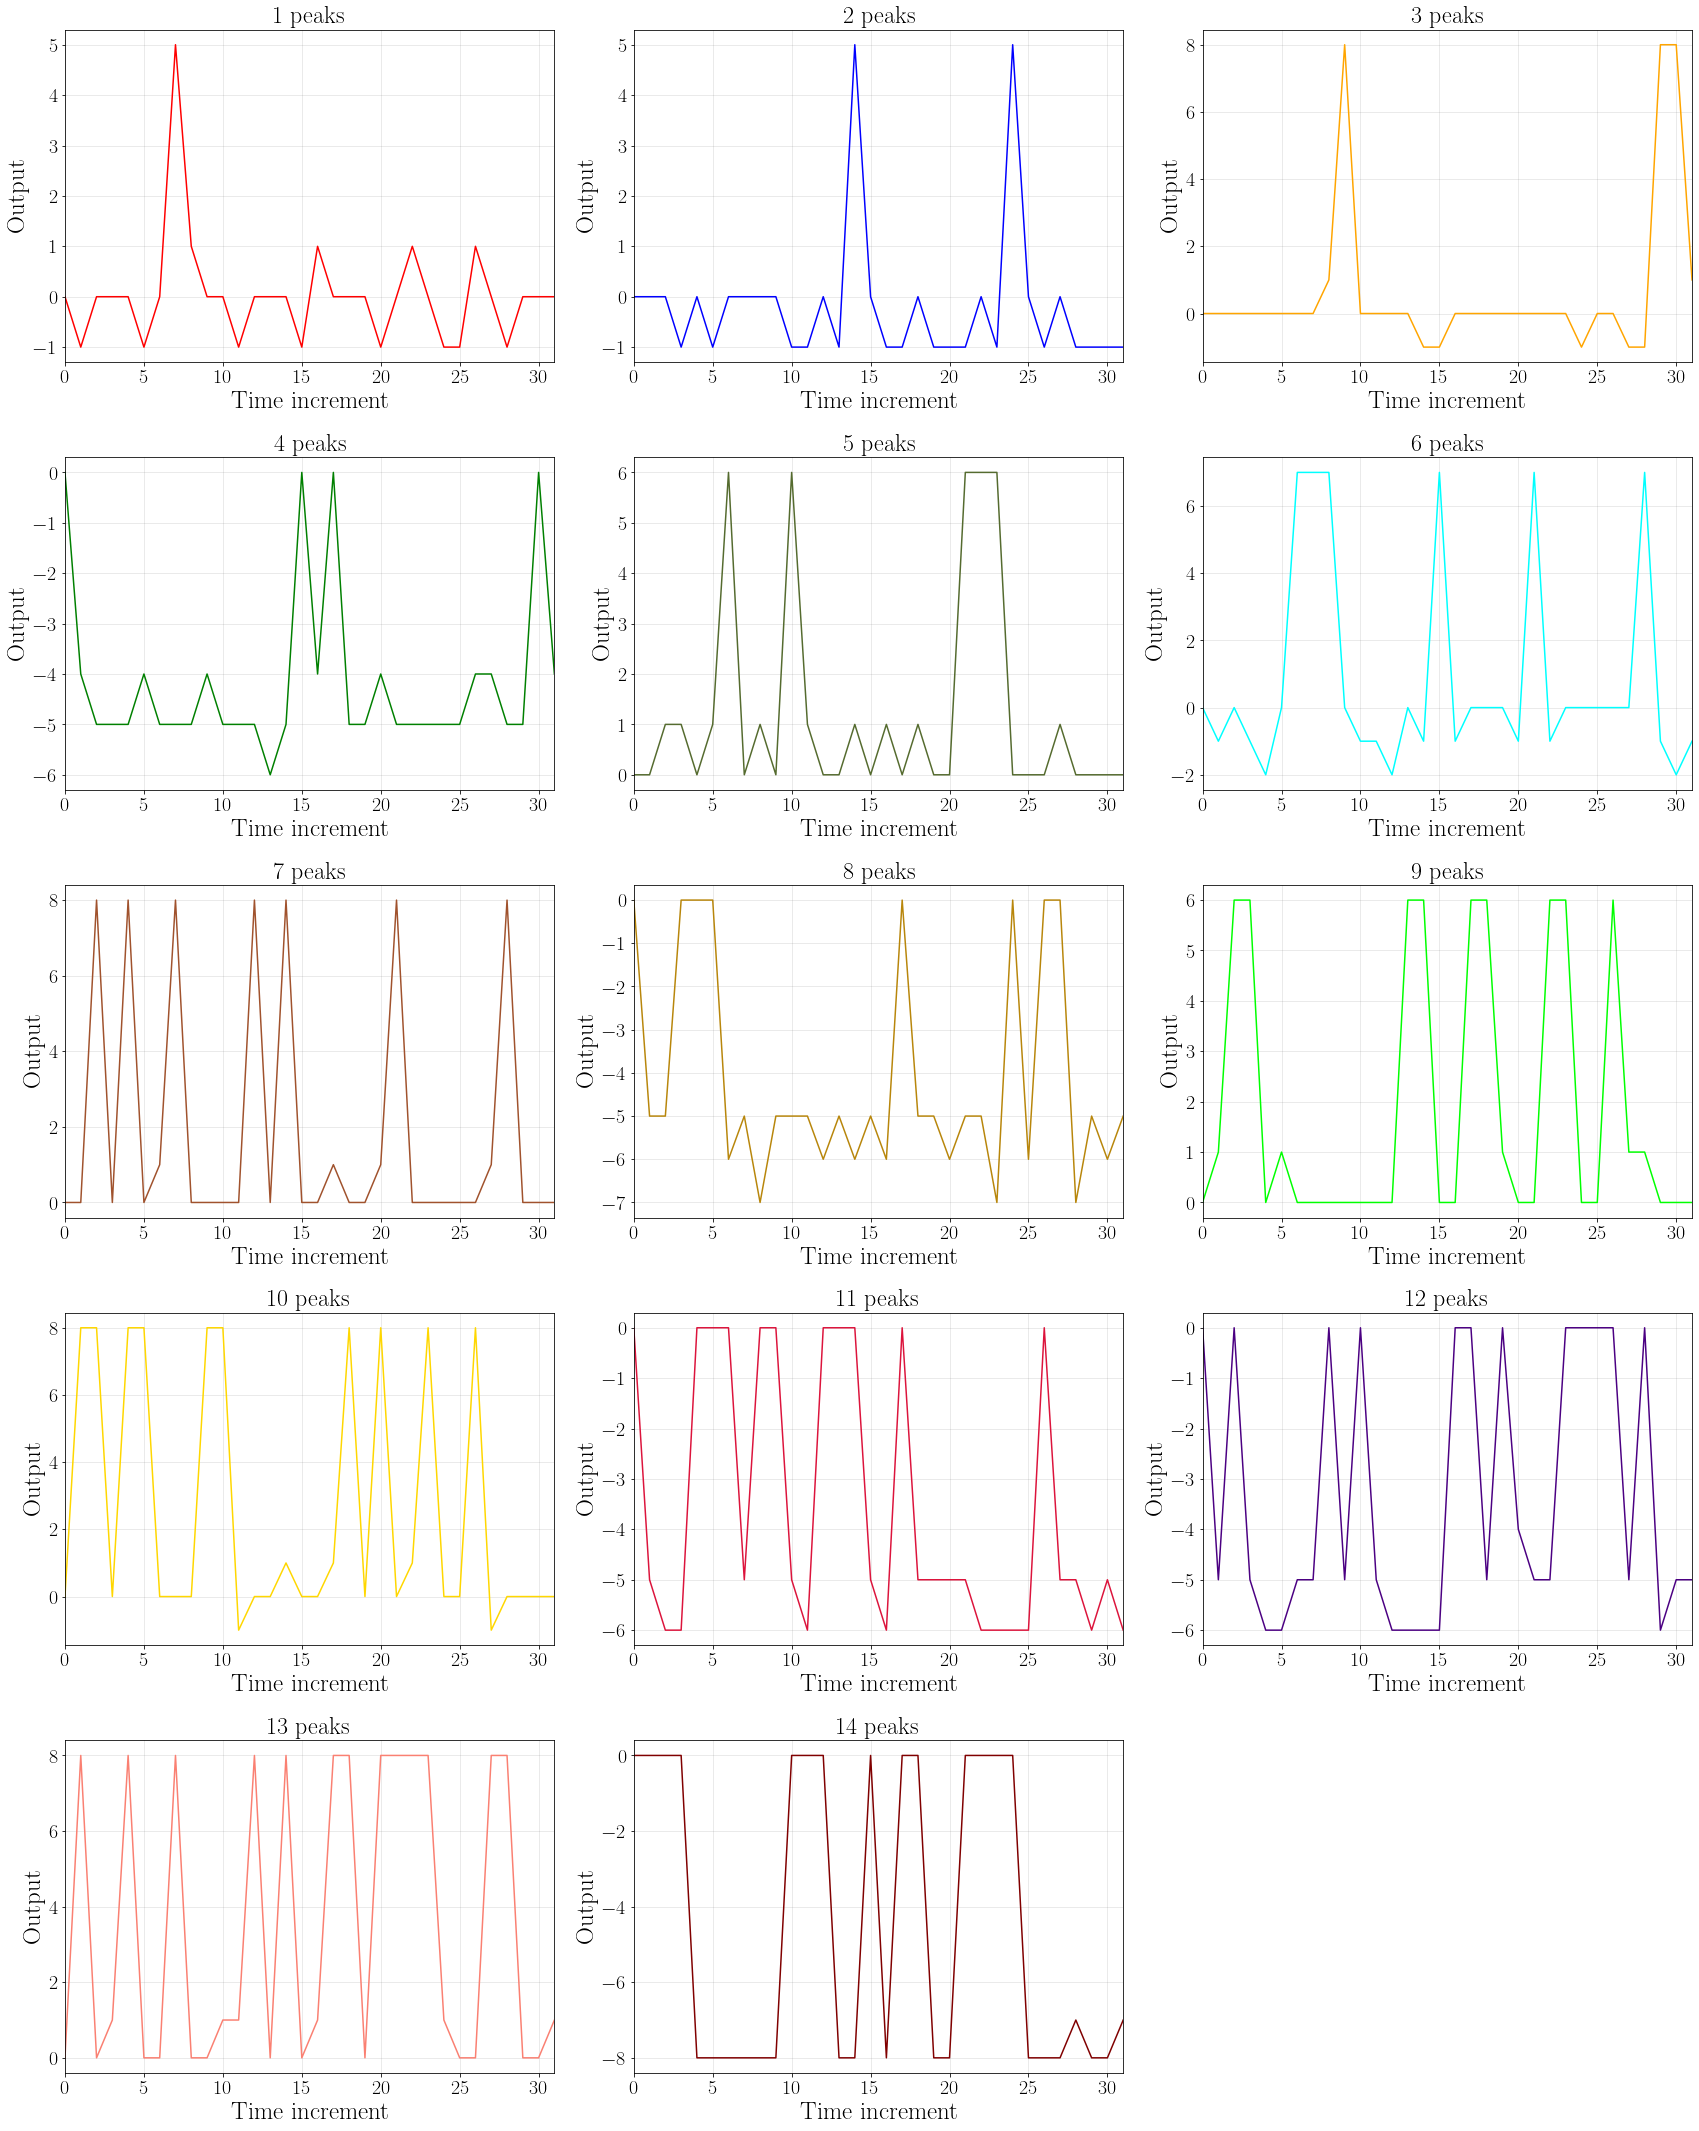

Layer 2 ----------


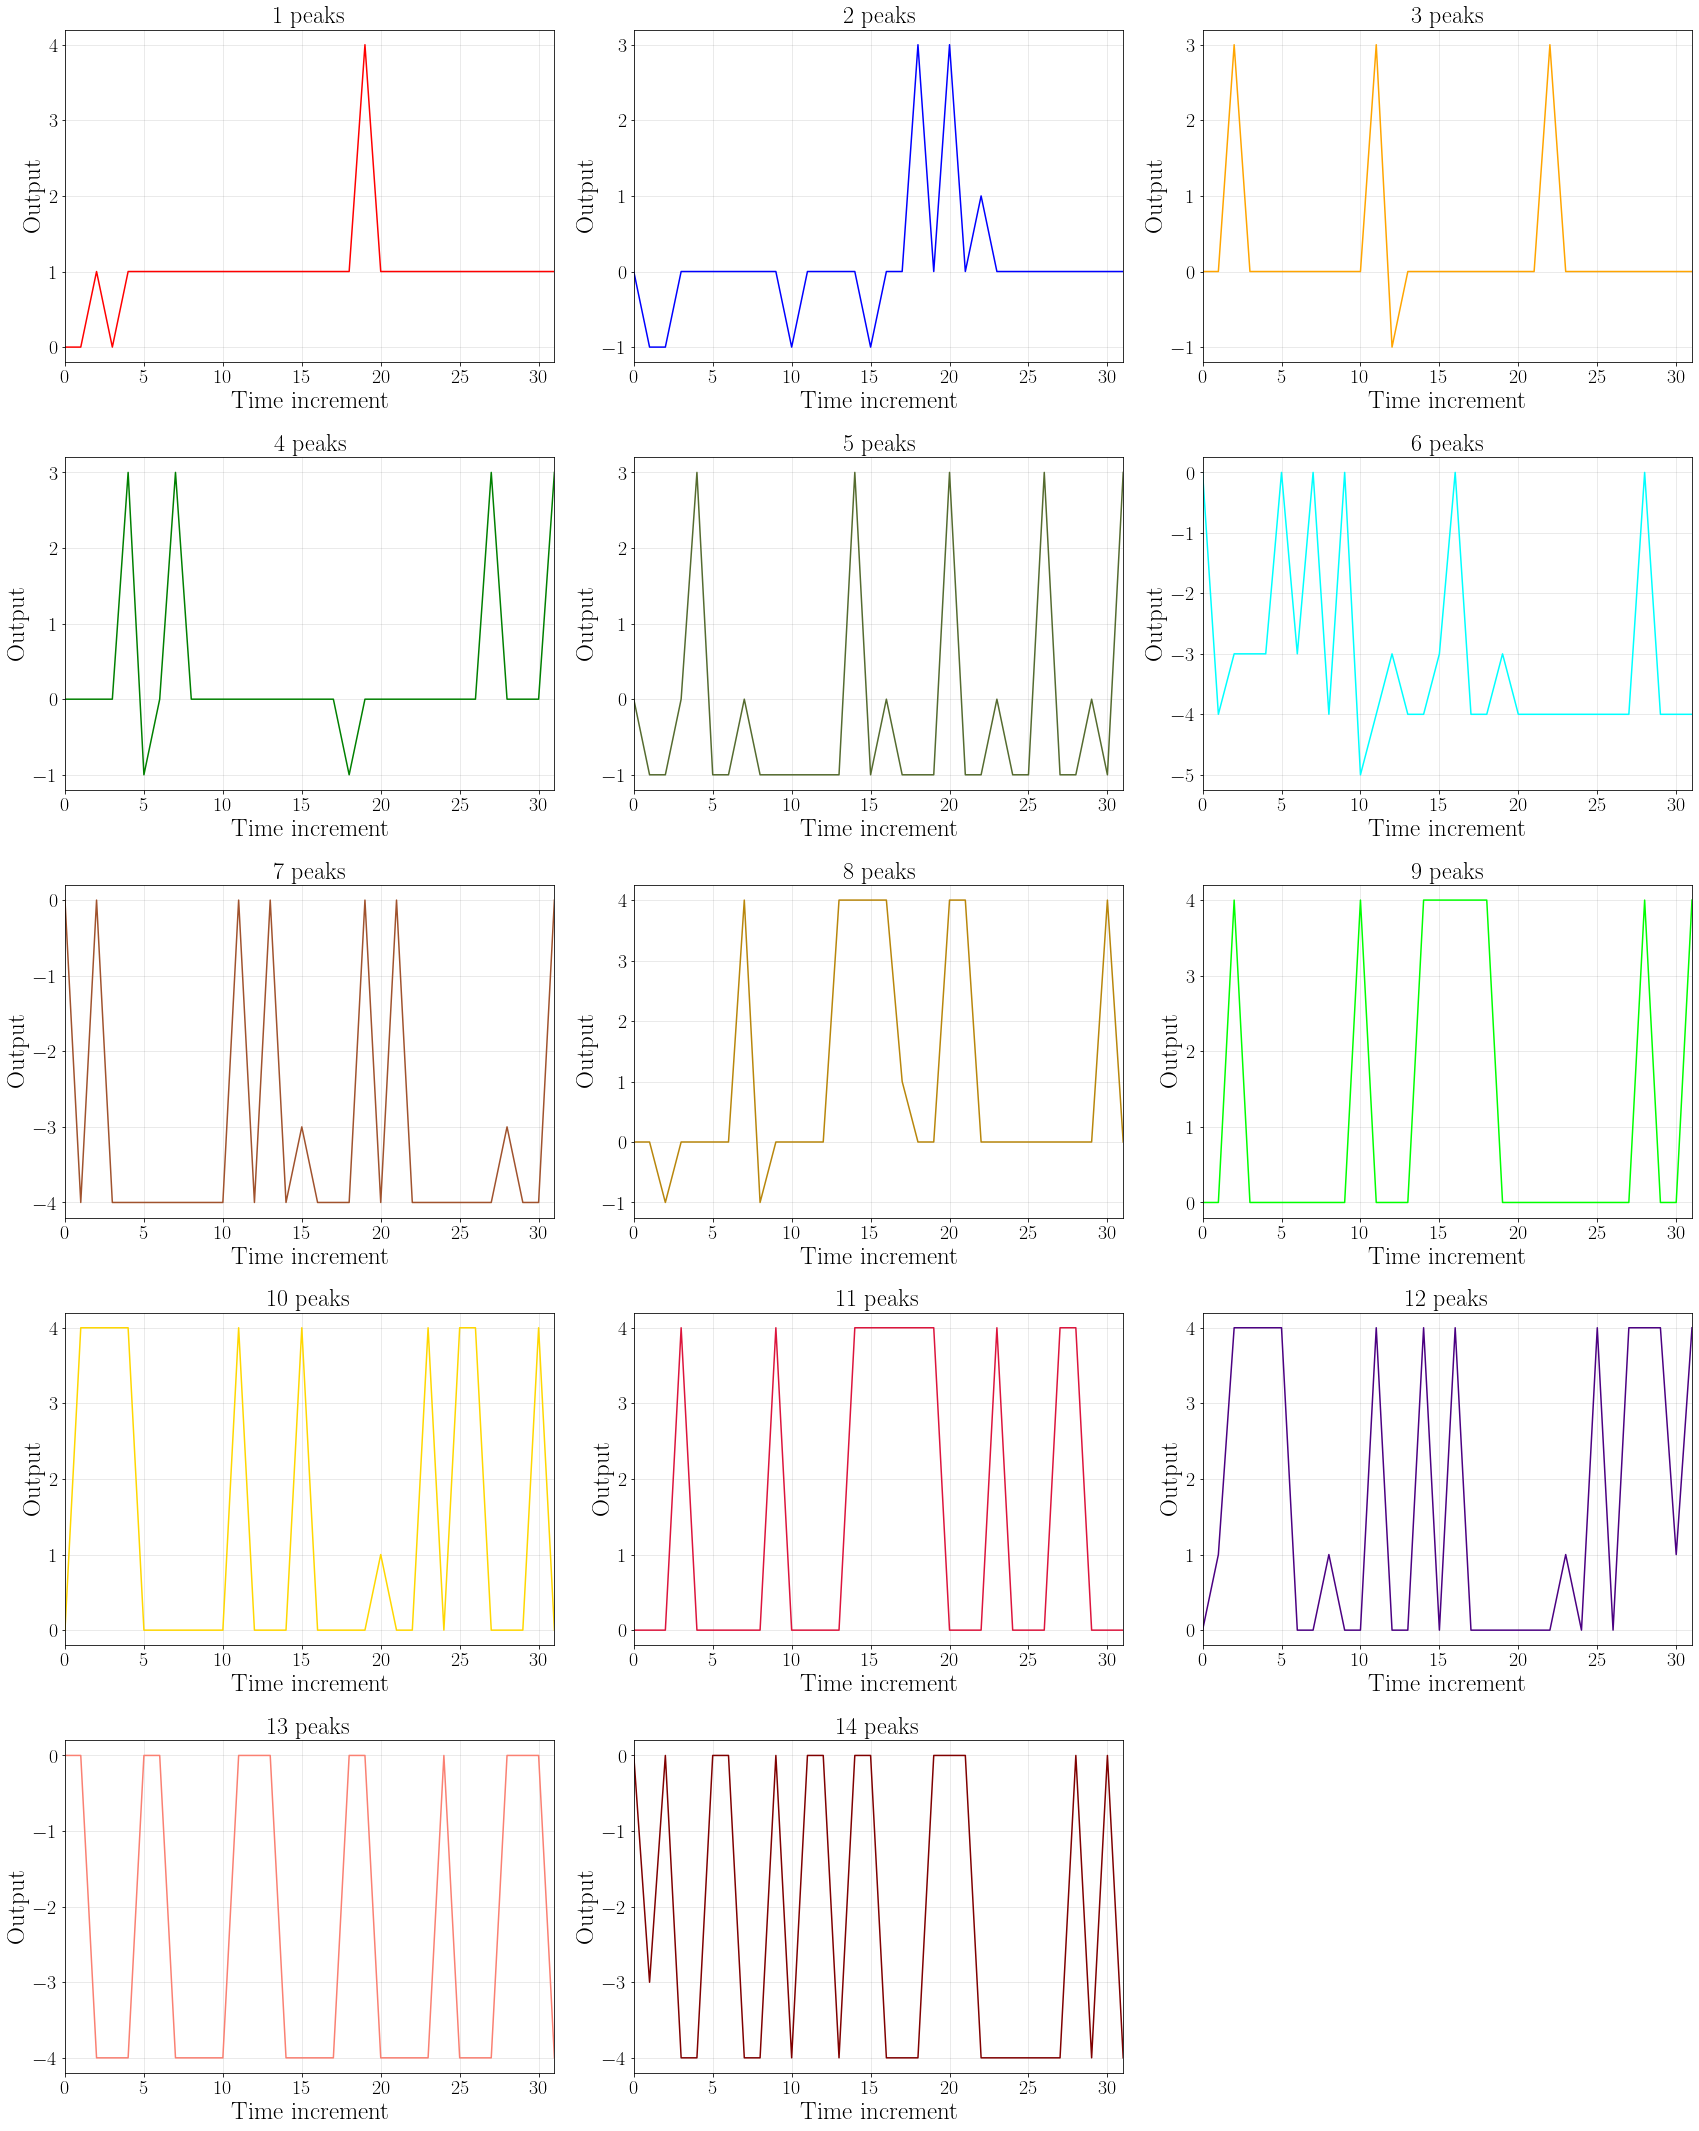

Layer 3 ----------


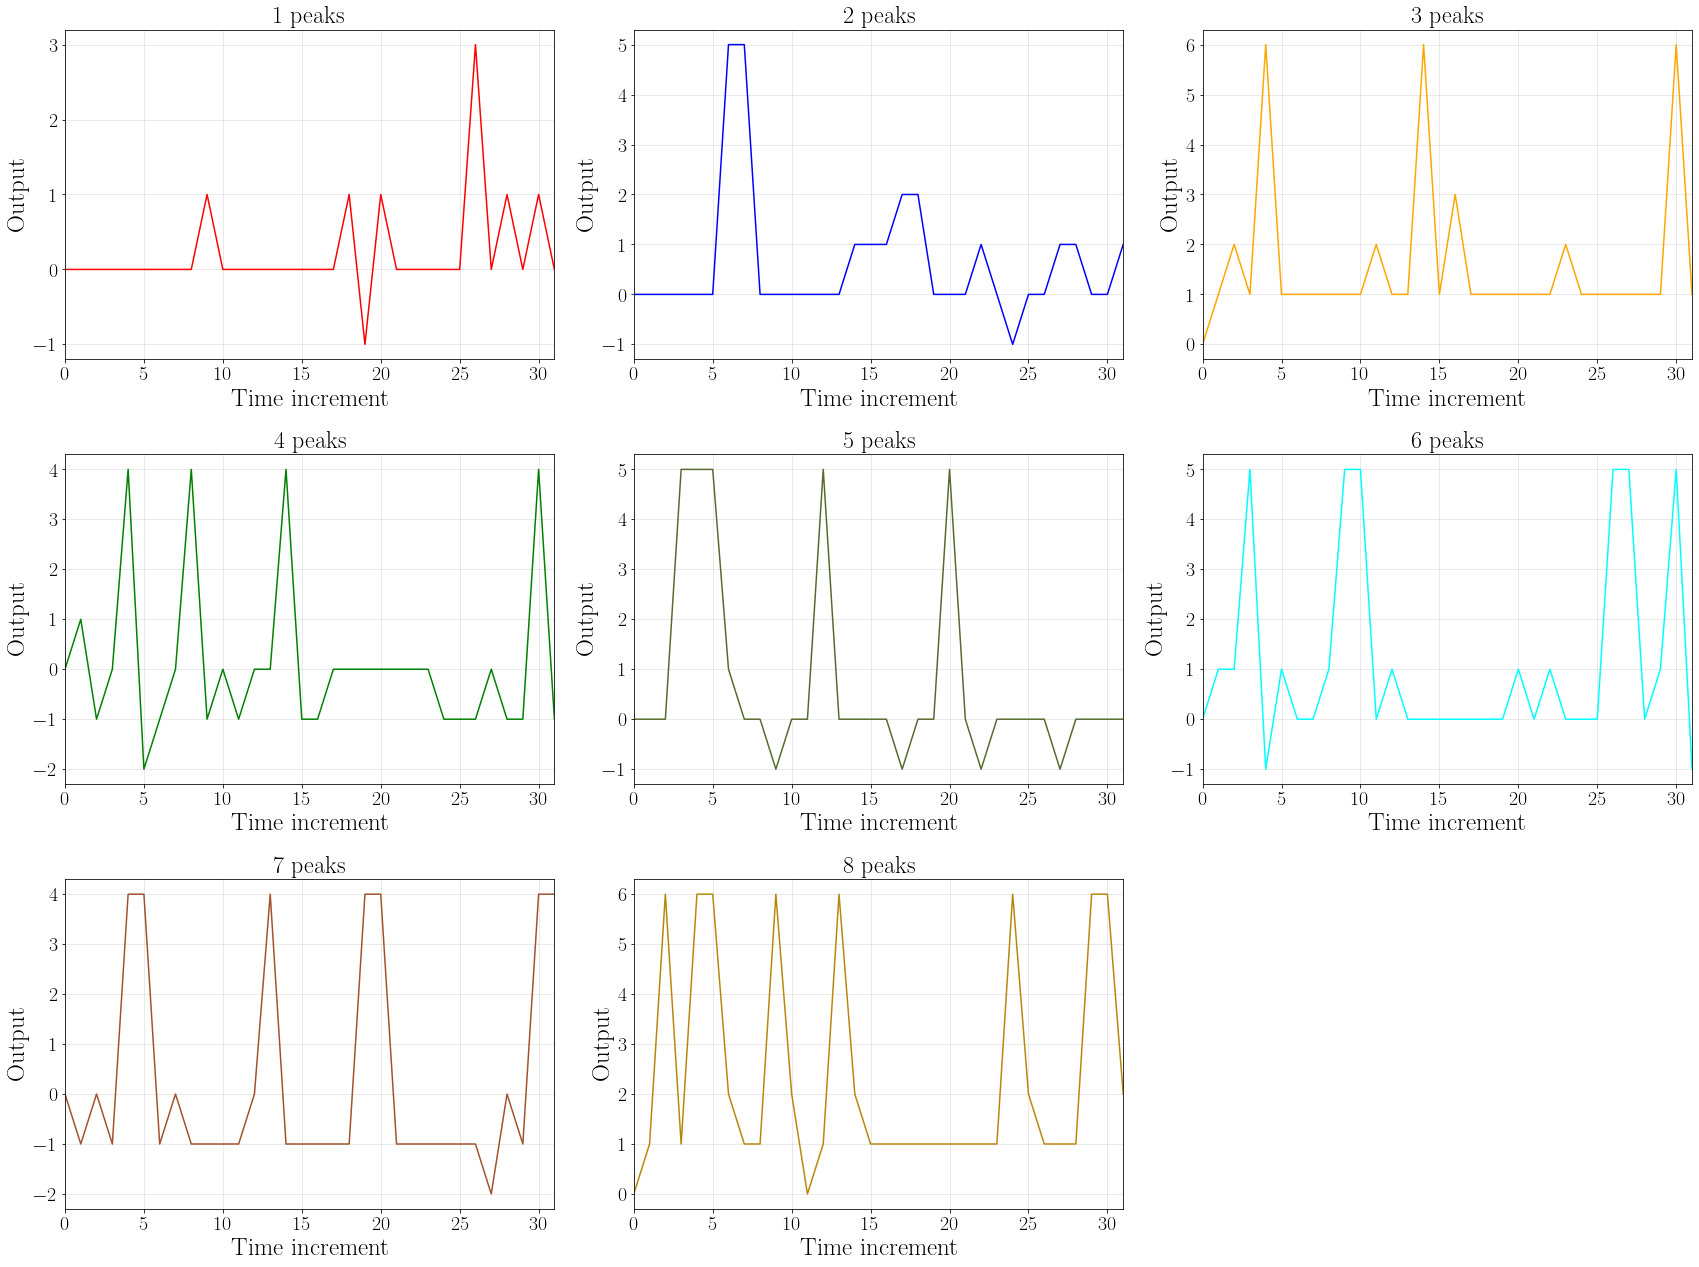

In [12]:
for layer, dataframe in dataframes.items():
    print("Layer", layer, "-"*10)
    clustering.plot_samples_clusters(
        dataframe,
        "nb_pos_peaks",
        dict_color_clu_labels=dict_color_clu_labels,
        title="{cluster_label} peaks"
    )
    plt.show()

### $\left(\eta, \phi\right)$

Layer 0 ====================


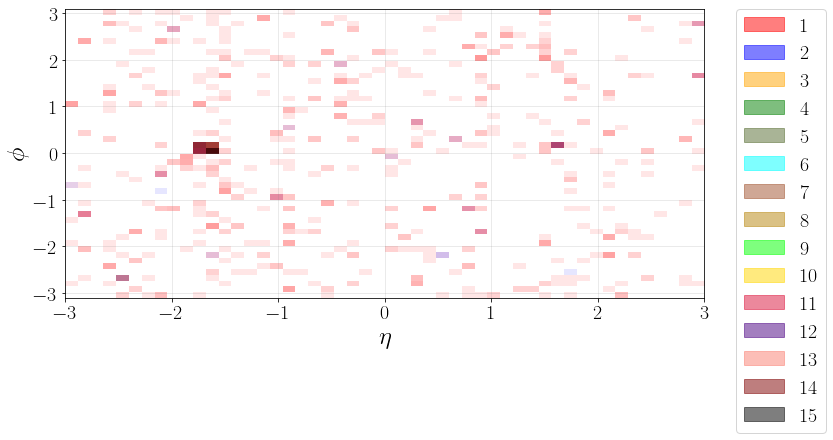

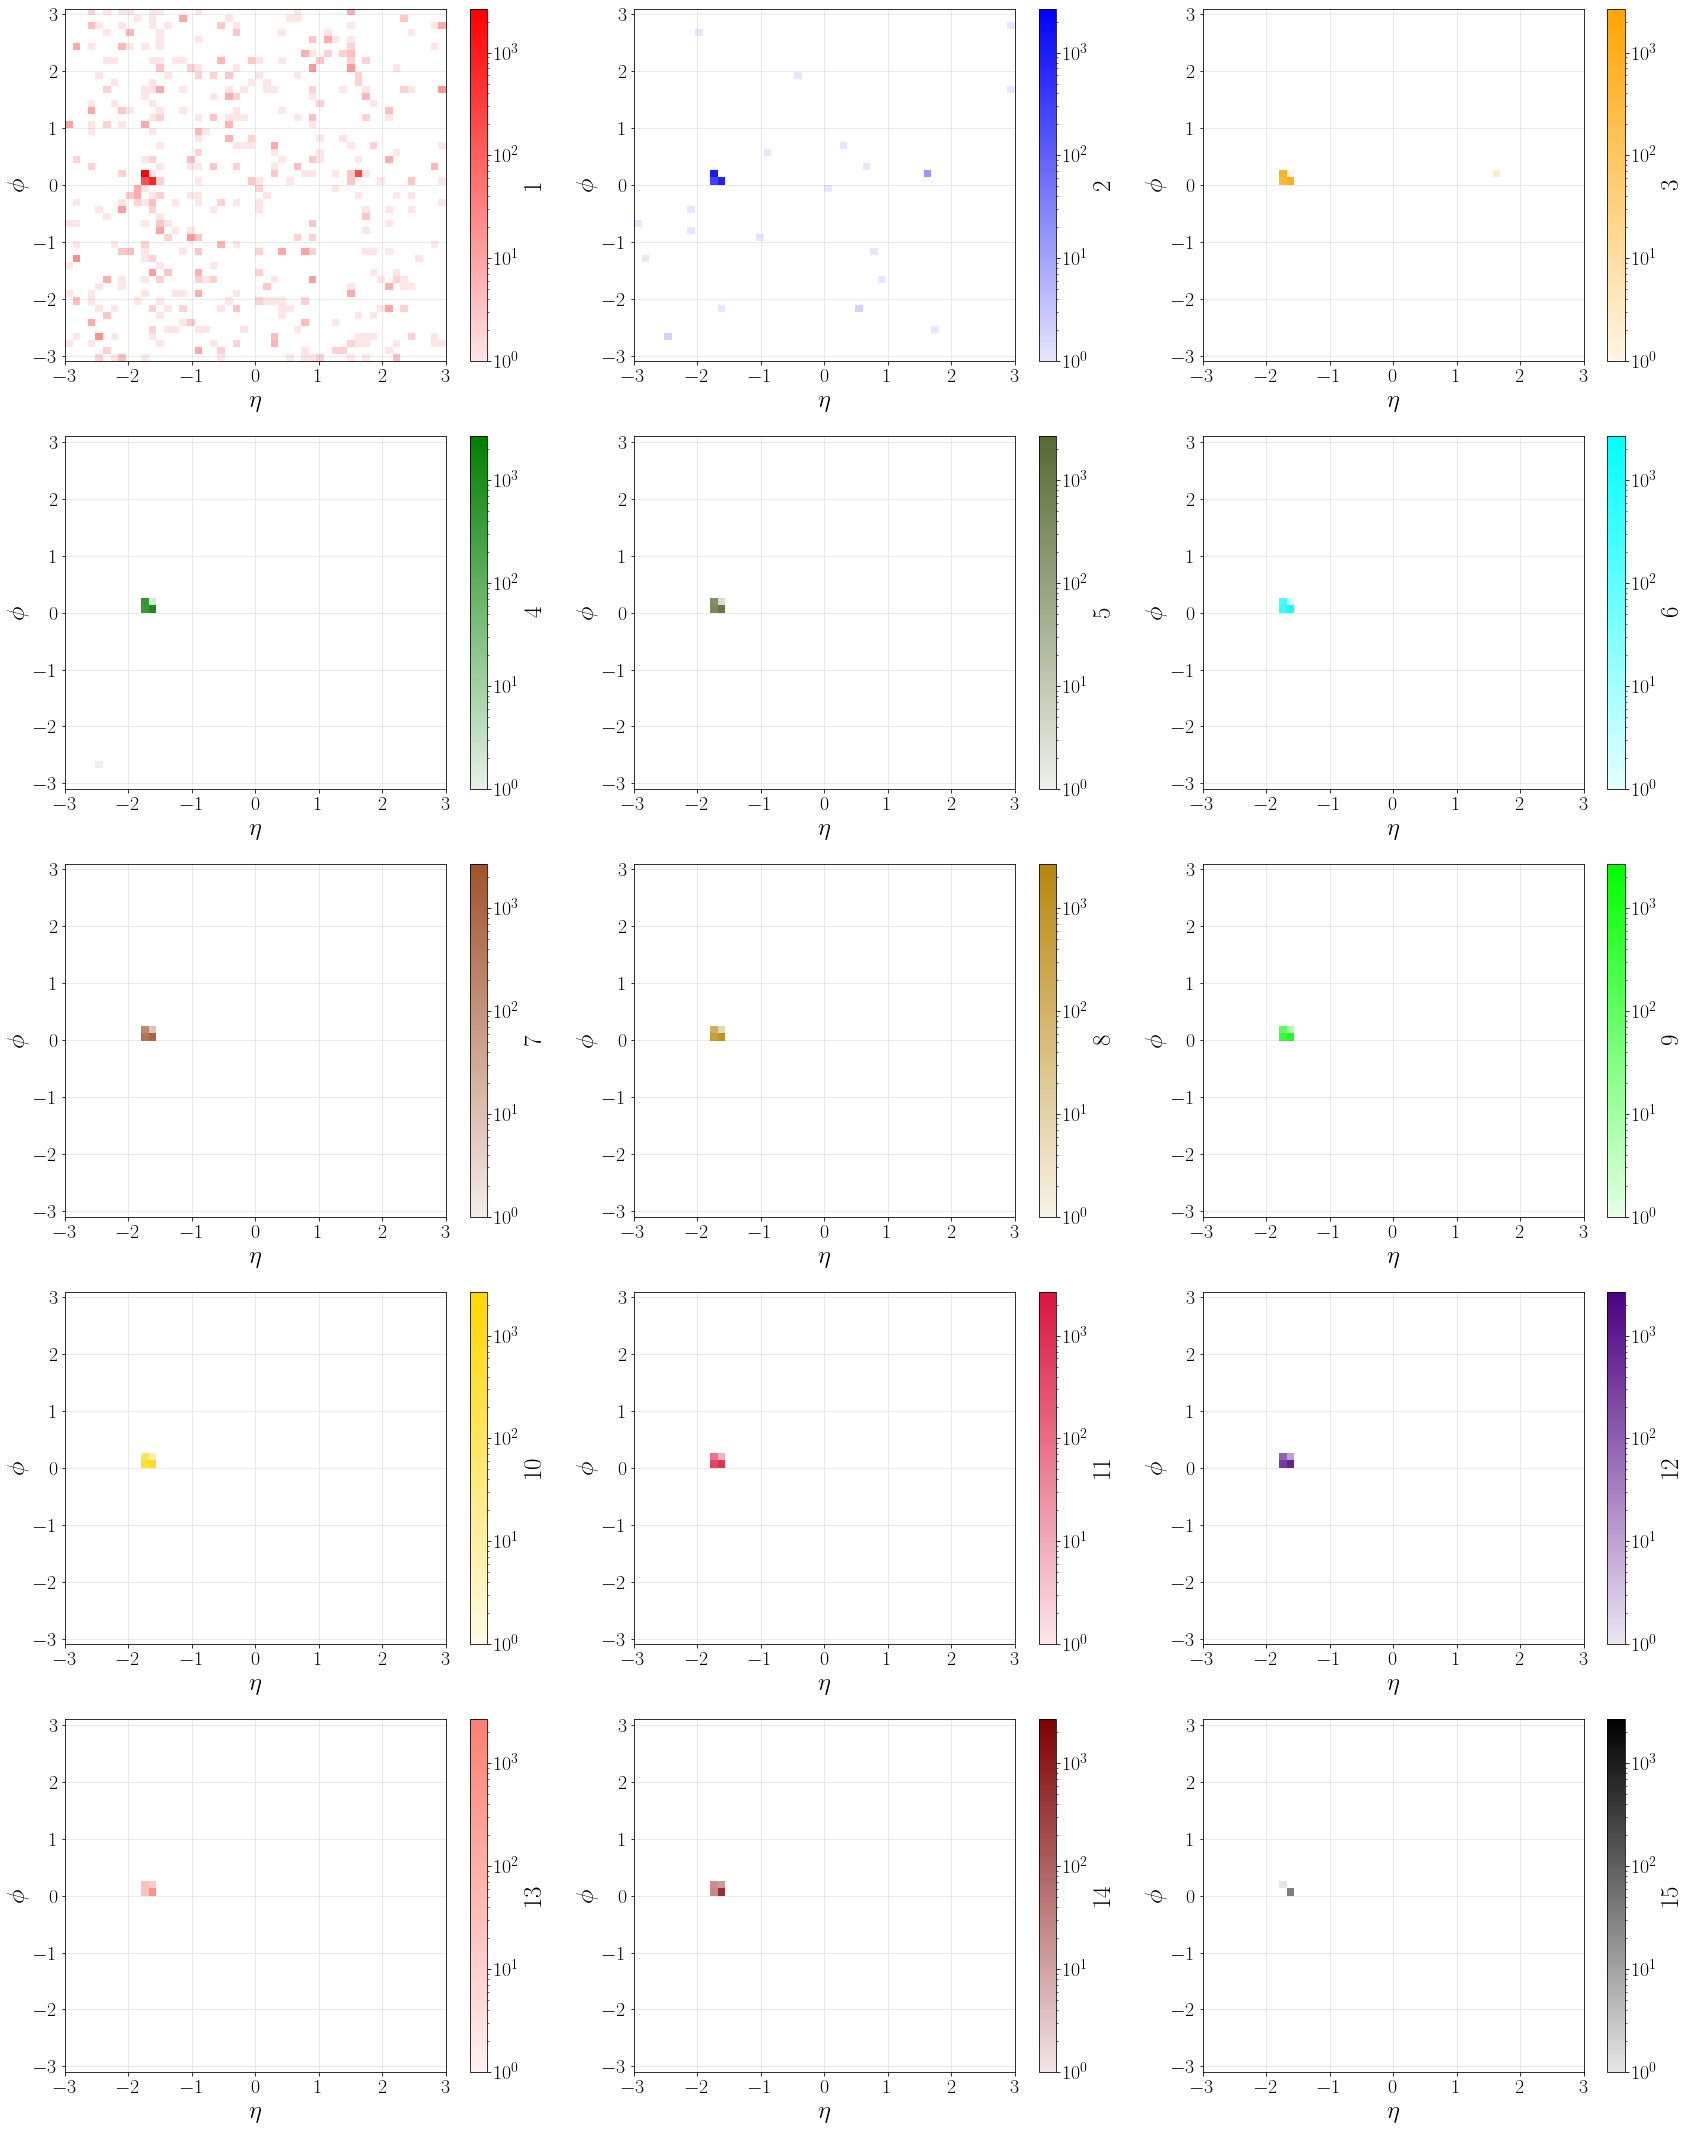

Layer 1 ====================


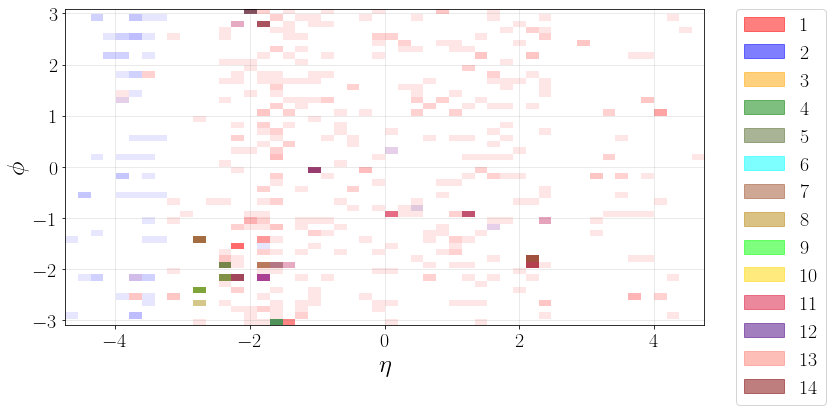

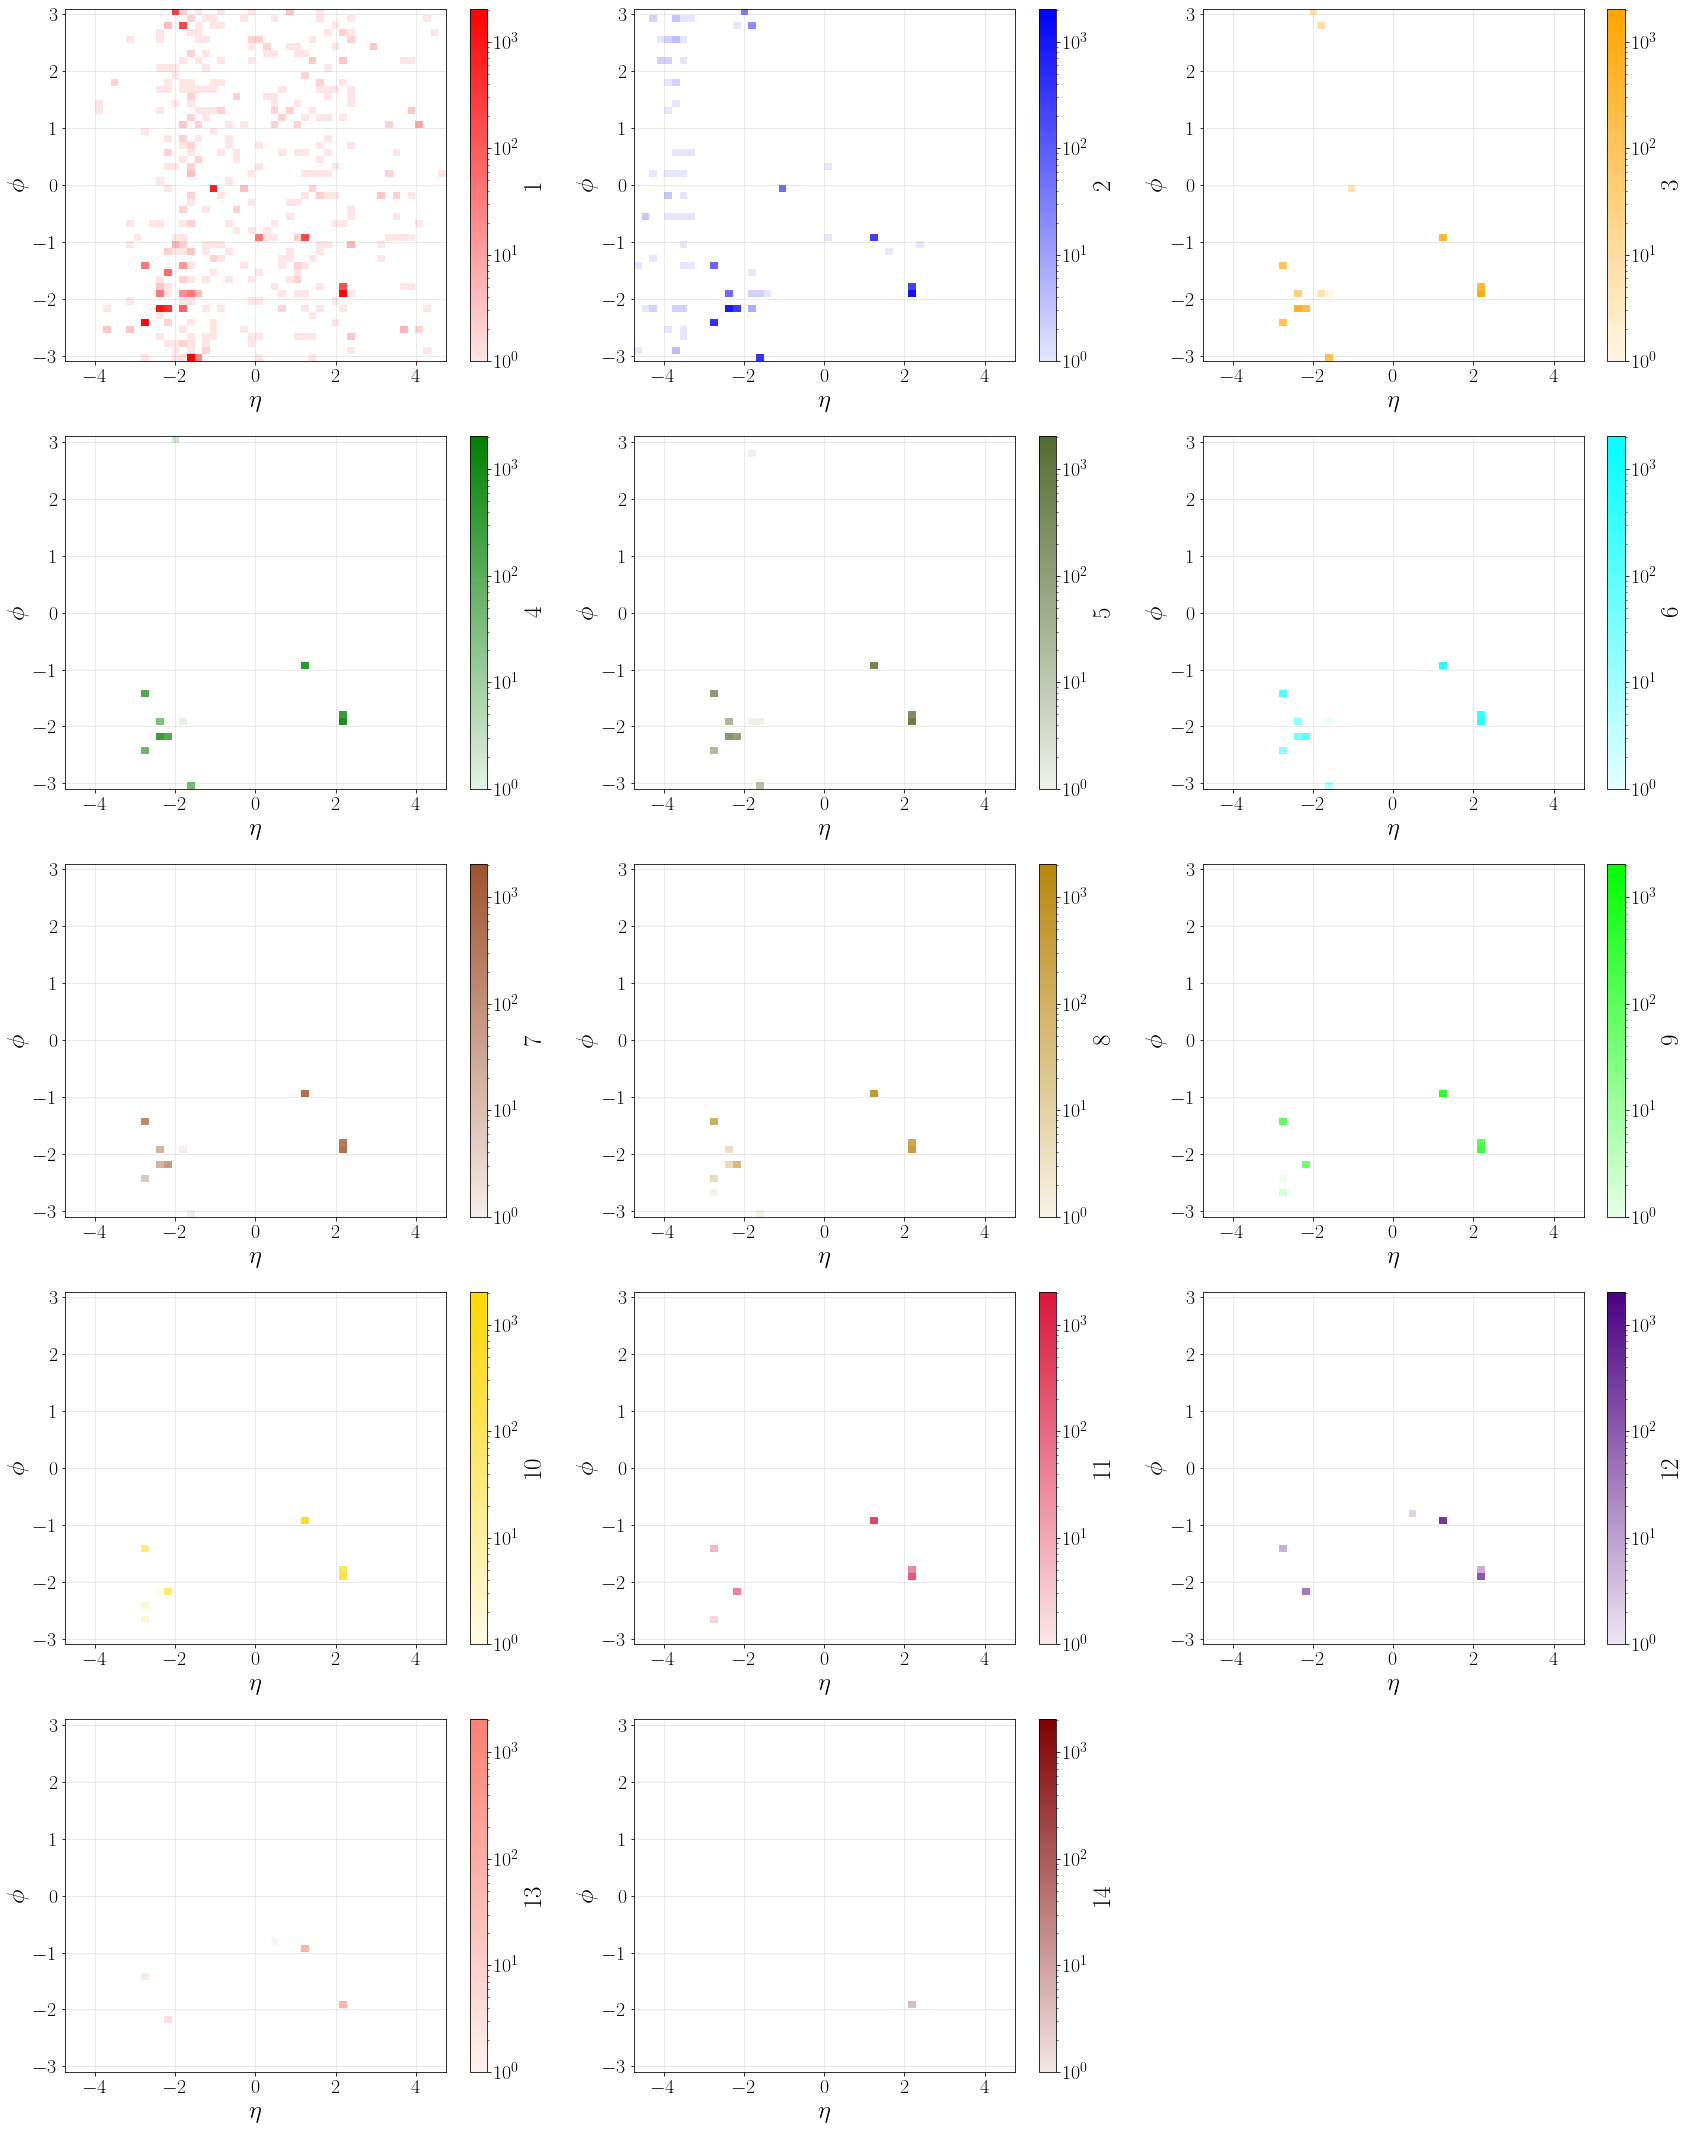

Layer 2 ====================


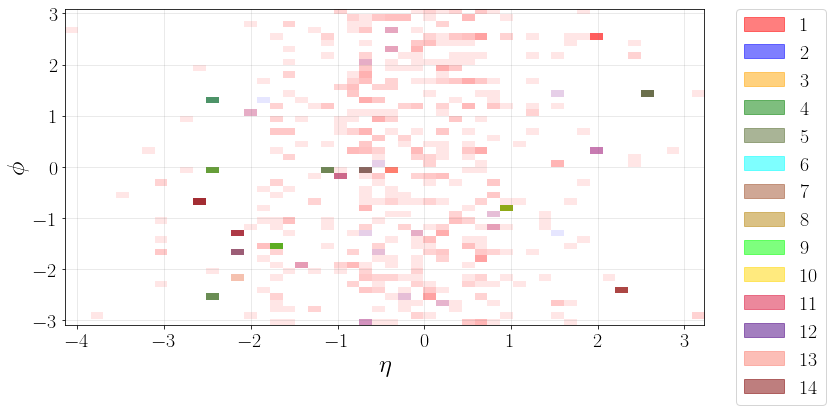

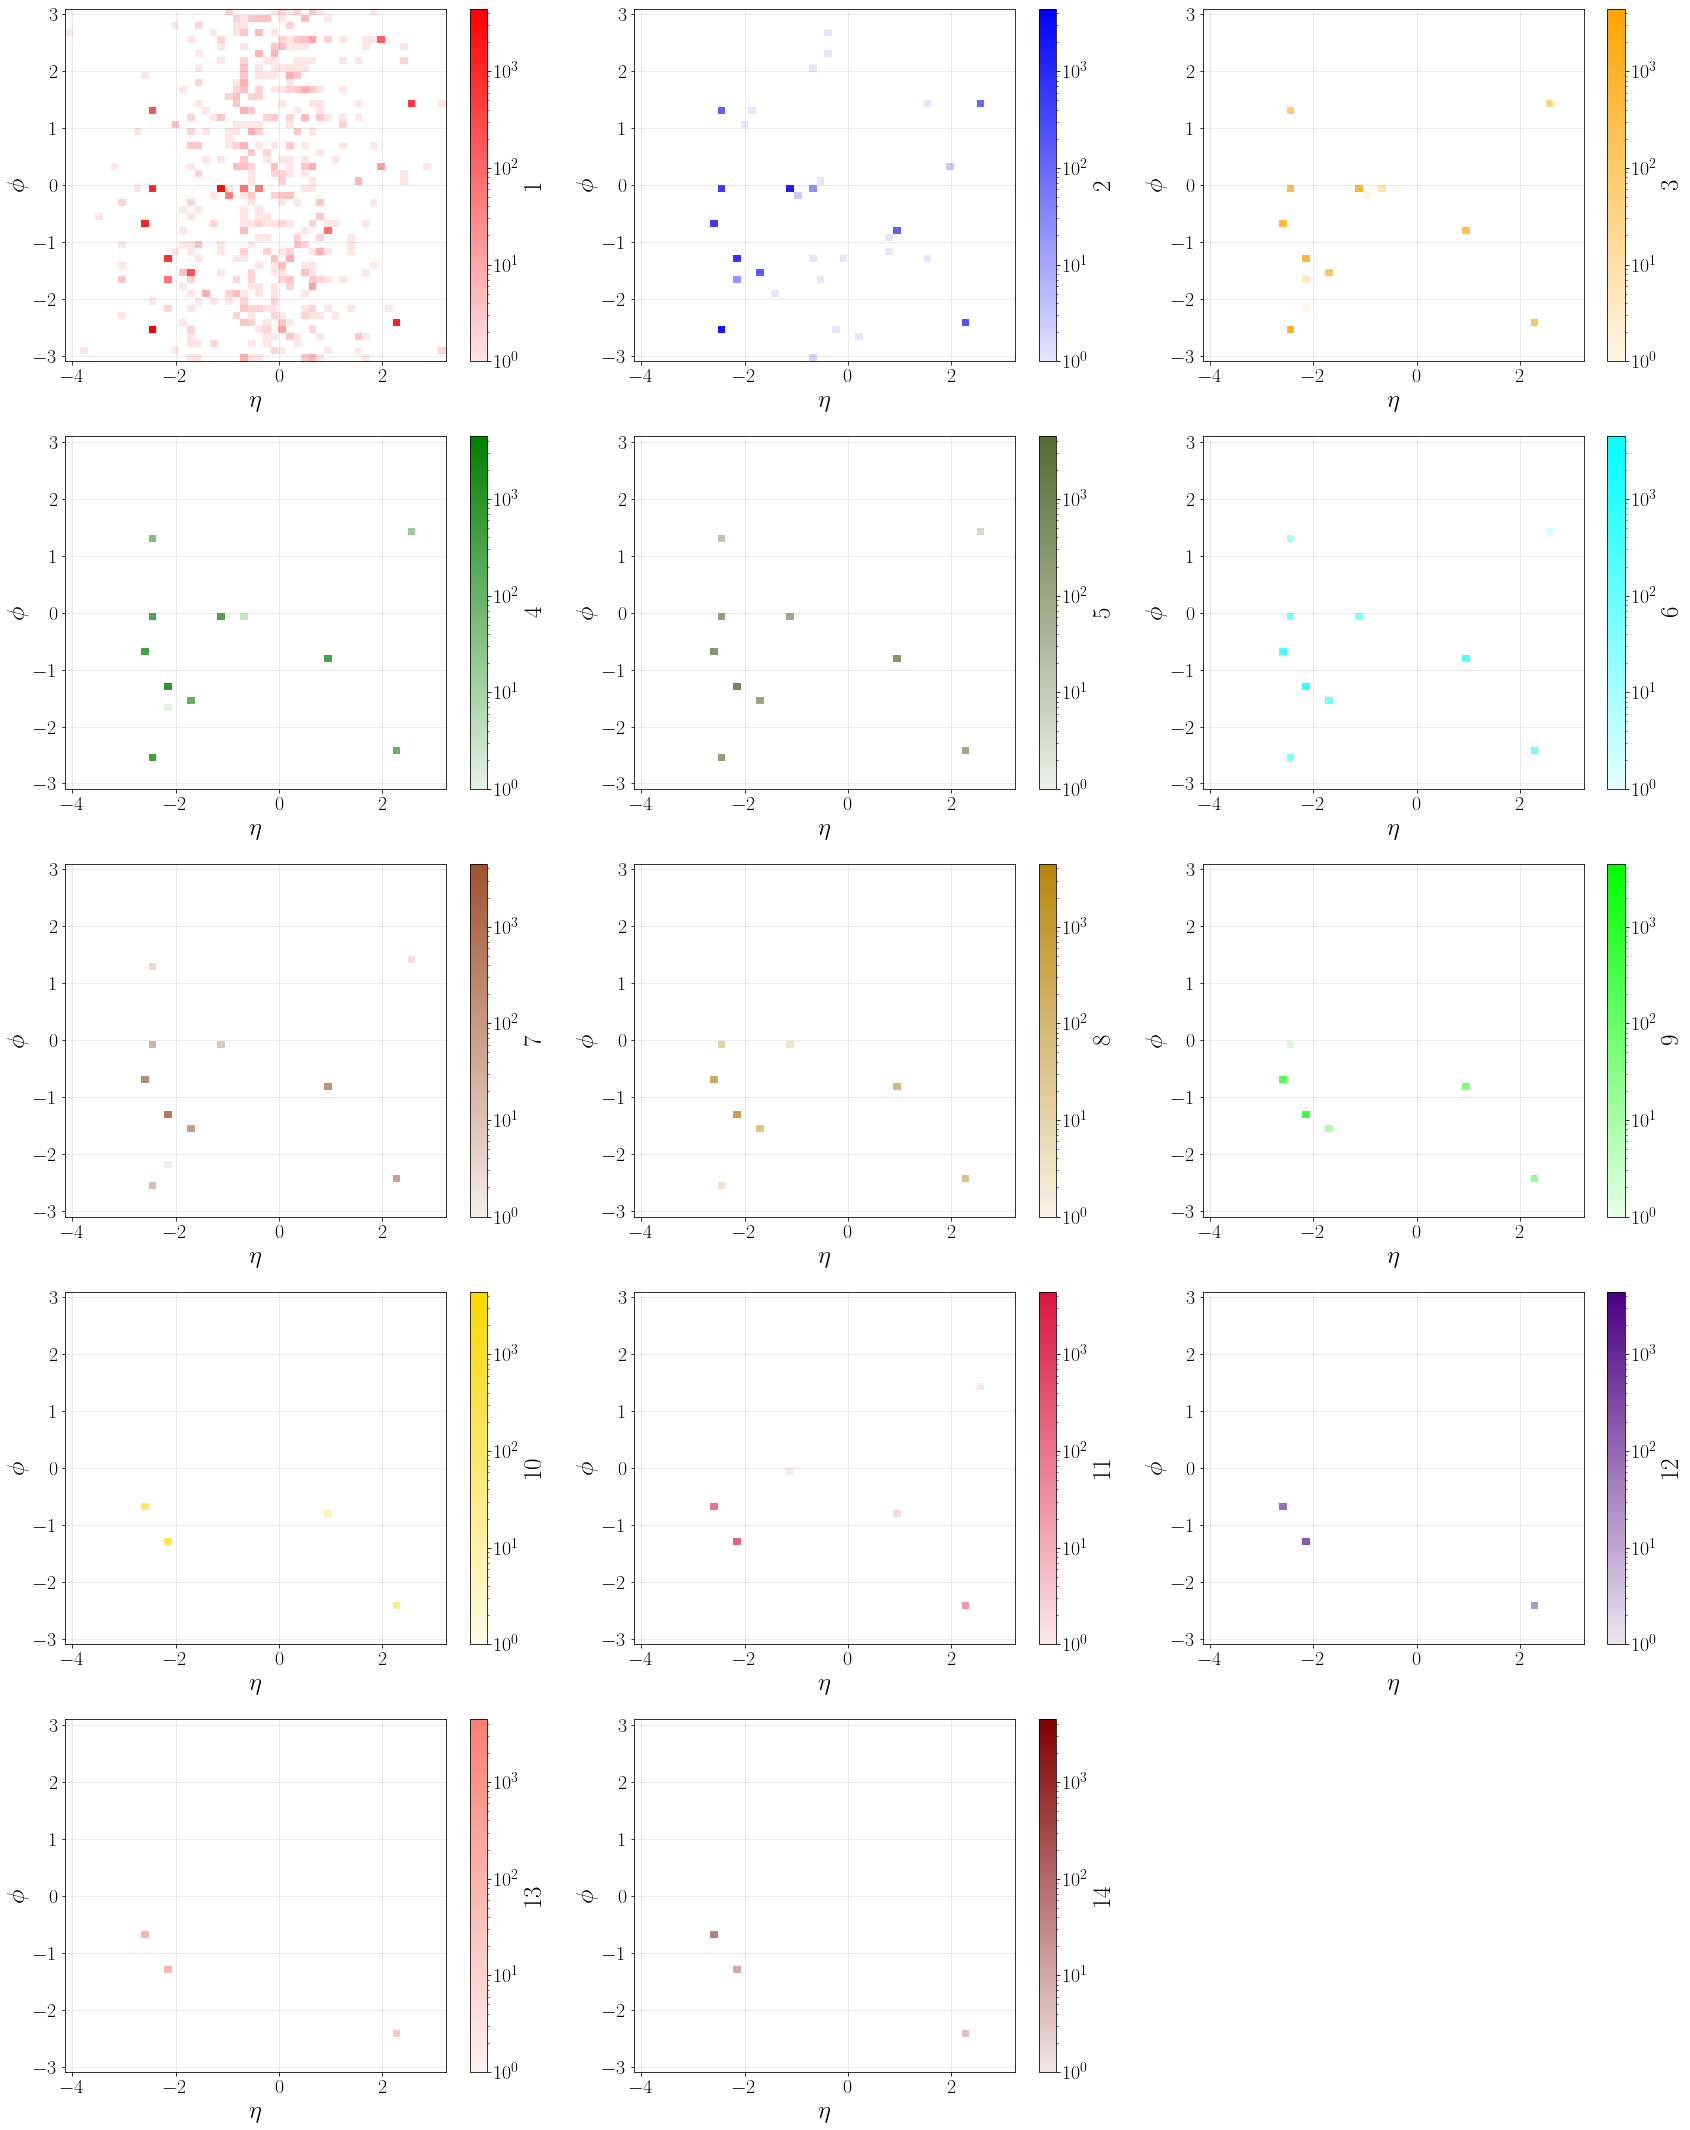

Layer 3 ====================


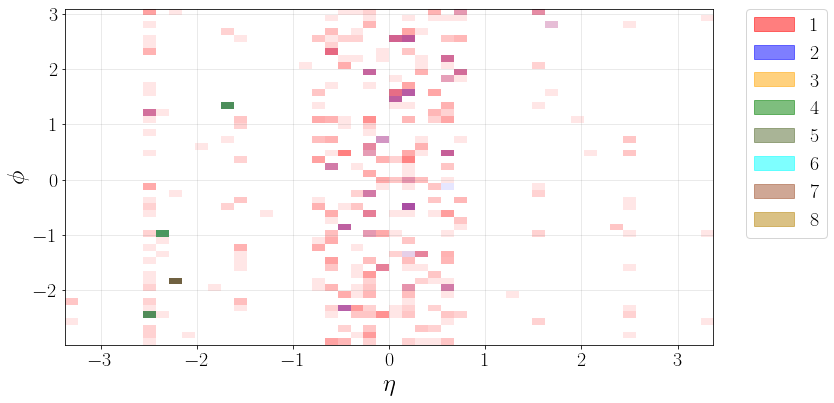

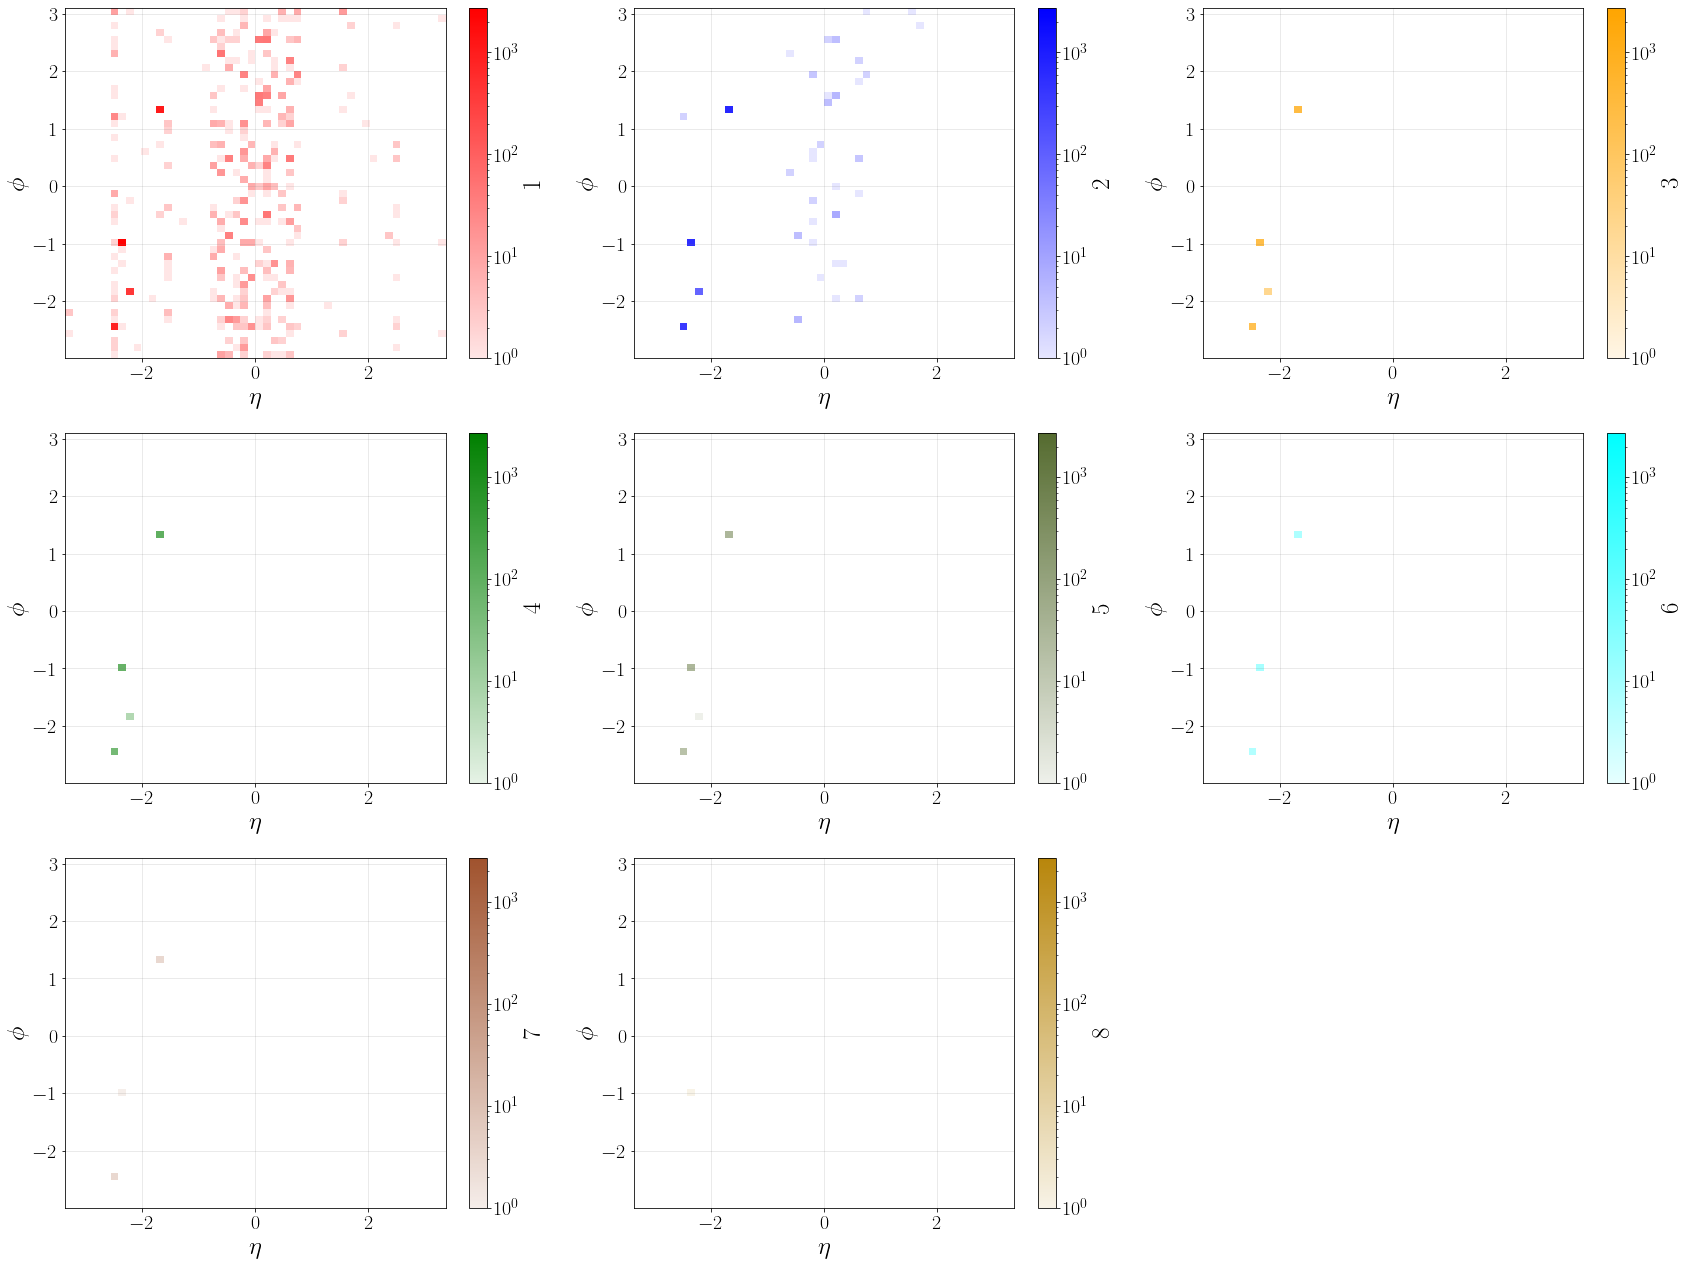

In [13]:
for layer, dataframe in dataframes.items():
    print("Layer", layer, '='*20)
    clustering.plot_clusters_hist2d(
        dataframe, 
        ["eta", "phi"],
        column_labels,
        "nb_pos_peaks",
        logscale=True,
        dict_color_clu_cats=dict_color_clu_labels,
        category_name=""
    )
    plt.show()

Layer 0 ====================


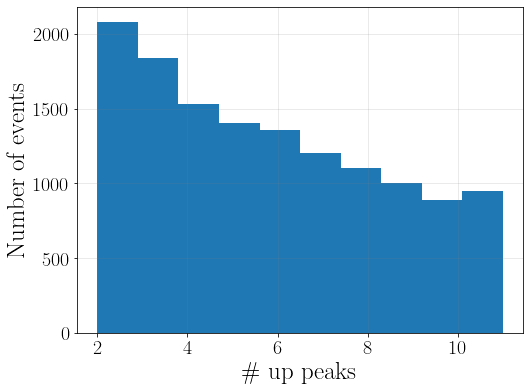

Layer 1 ====================


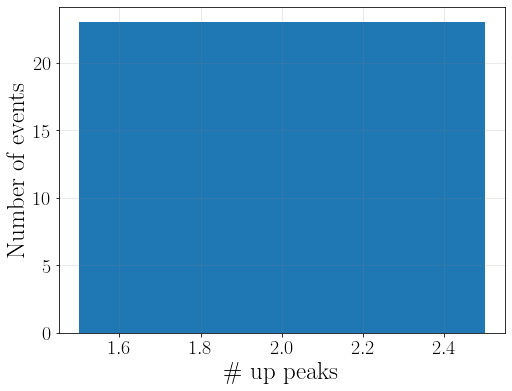

Layer 2 ====================


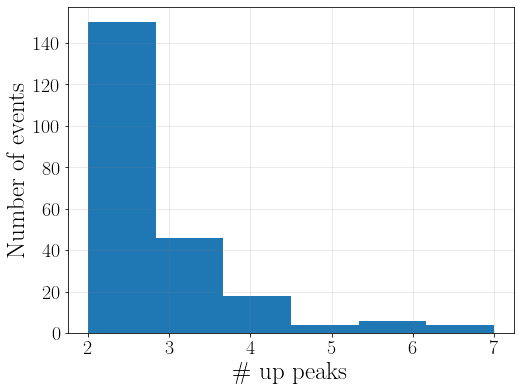

Layer 3 ====================


ValueError: min() arg is an empty sequence

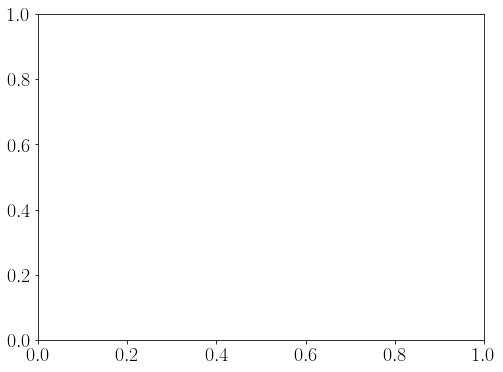

In [7]:
for layer, dataframe in dataframes.items():
    print("Layer", layer, '='*20)
    lp.plot_hist(
        dataframe.query("max - min > 10 and nb_pos_peaks< 12 and nb_pos_peaks > 1")["nb_pos_peaks"], 
        column_labels["nb_pos_peaks"],
        bins="discretised"
    )
    plt.show()

This type of background is localised in the detector, and happen only in a few cells.

In [14]:
channel_id_counts_layers = {}
for layer, dataframe in dataframes.items():
    channel_id_counts_layers[layer] = get_channel_id_counts(dataframe)

    # print("Layer", layer, '-'*5)
    # print(channel_id_counts_layers[layer])

In [15]:
predominant_channel_id_counts_layers = select_new_predominant_channelId(
    channel_id_counts_layers,
    min_count=100
)

In [16]:
predominant_channel_id_counts_layers

{0: {979369984: 12941, 979372544: 6421, 979372032: 4889, 989856768: 266},
 1: {999348224: 7645,
  970525696: 4954,
  983640576: 3152,
  984113152: 2688,
  999350784: 2362,
  984356352: 2267,
  983624192: 1507,
  981209088: 995,
  947967488: 823,
  973121024: 316,
  983113728: 217,
  973107200: 190},
 2: {984402944: 7006,
  982639616: 6345,
  948035072: 5716,
  981223424: 4591,
  981270016: 2472,
  970571264: 1660,
  997330432: 1437,
  984394752: 1393,
  982599680: 992,
  997328384: 985,
  991235584: 787,
  976890368: 530,
  995734016: 150},
 3: {982150144: 3643, 976894464: 2253, 984428032: 1507, 983196160: 513}}

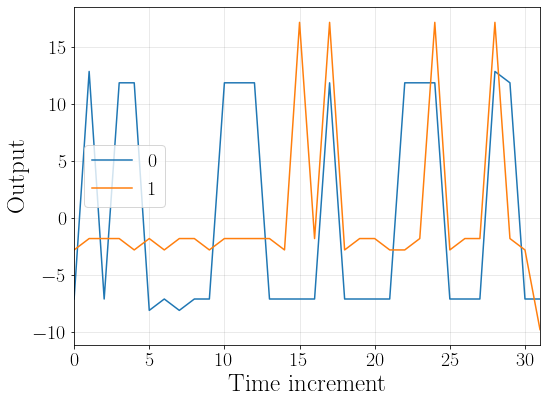

In [8]:
lp.plot_samples_lots(dataframes[0].query("channelId==979369984").sample(2), minus_mean=True)

### Number of peaks

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\max{e} - \\min{e}$', ylabel='$\\# \\text{ up peaks}$'>)

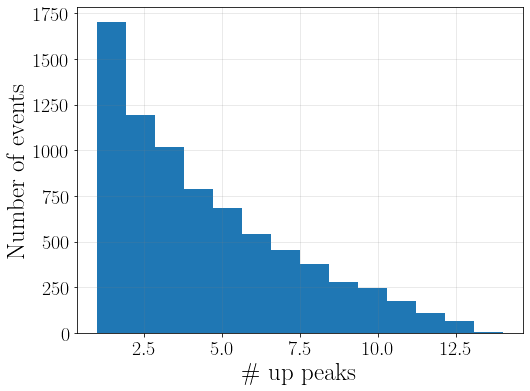

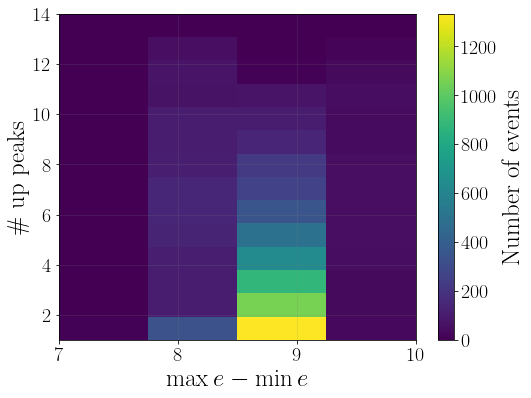

In [9]:
df = dataframes[1].query("channelId==999348224")

lp.plot_hist(
    df["nb_pos_peaks"], column_labels["nb_pos_peaks"],
    bins="discretised"
)
lp.plot_hist2d(
    df["max_m_min"], df["nb_pos_peaks"],
    column_labels["max_m_min"], column_labels["nb_pos_peaks"],
    bins="discretised"
)


In [66]:
# df = df.query("max - min < 23" and "max - min > 18")

In [67]:
nb_peaks_mean = df["nb_pos_peaks"].mean()

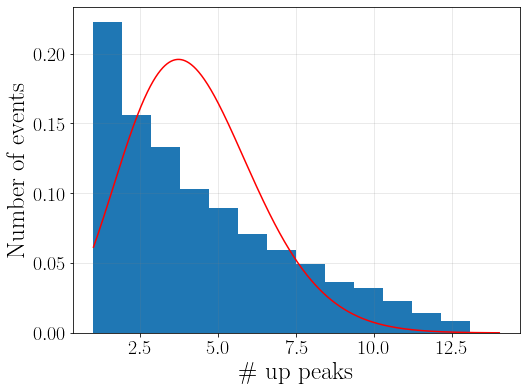

In [68]:
import scipy
def poisson(k, mu):
    return np.power(mu, k) / scipy.special.factorial(k) * np.exp(-mu)

x = np.linspace(df["nb_pos_peaks"].min(), df["nb_pos_peaks"].max(), 1000)
y = poisson(x, nb_peaks_mean)


fig, ax = lp.plot_hist(
    df["nb_pos_peaks"], column_labels["nb_pos_peaks"],
    bins="discretised",
    normalise=True
)

ax.plot(x, y, color='r')



In [64]:
prob_peak = nb_peaks_mean / 32

### Time correlation
Are these type of events happening at specific time, or is it just all the time ?

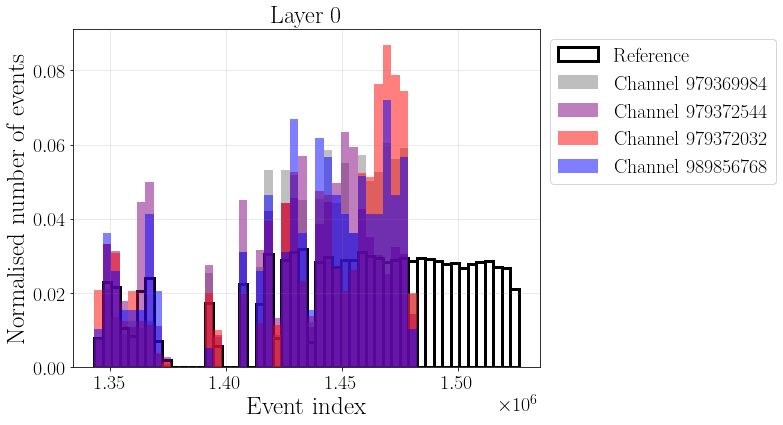

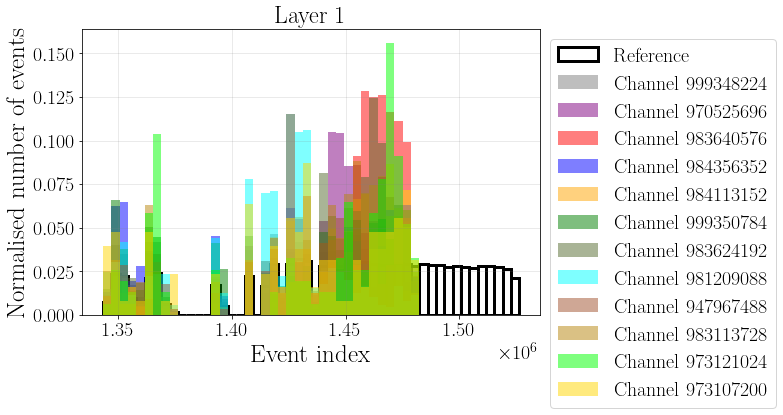

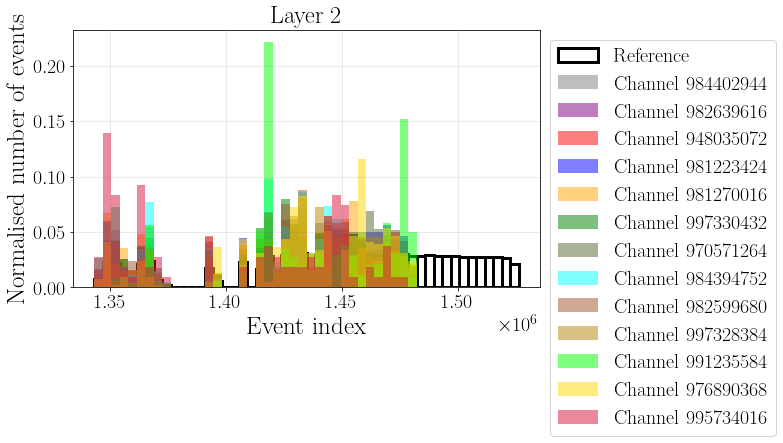

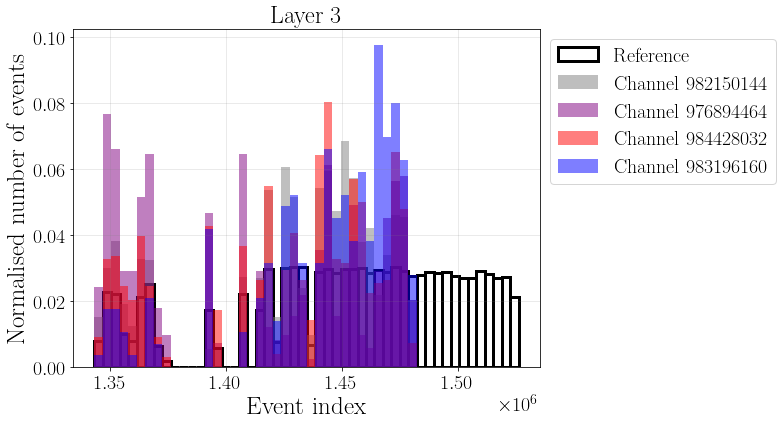

In [48]:
for layer in layers:
    very_periodic_dataframes_most = {}
    for channel_id, count in channel_id_counts_layers[layer].items():
        if int(count) > 100:
            very_periodic_dataframes_most[channel_id] = dataframes[layer].query(
                f"channelId=={channel_id}"
            )
    # fig, ax = plt.subplots(figsize=(8, 6))
    # for channel_id, dataframe in very_periodic_dataframes.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ref_dataframe_layer = ref_dataframe.query(f"layer=={layer}")
    _, bins, _ = ax.hist(
        ref_dataframe_layer["IEvent"],
        label="Reference",
        facecolor="None",
        ls='-', lw=3,
        edgecolor="k",
        weights = np.ones_like(ref_dataframe_layer["IEvent"]) / len(ref_dataframe_layer),
        bins=50
    )
    
    lp.multi_plot_hist_same_col(
        list(very_periodic_dataframes_most.values()), 
        "IEvent",
        column_label="Event index",
        list_labels=[f"Channel {channel_id}" for channel_id in very_periodic_dataframes_most.keys()],
        alpha=0.5,
        normalise=True,
        method="one_ax",
        list_colors=list(dict_color_clu_labels.values()),
        #['r', 'g', 'darkorange', 'purple', 'b', 'y', 'g'],
        return_bins=True,
        axes=ax,
        bins=bins,
        # with_err=True
        # min_max=(1.355e6, 1.356e6)
        # min_max=(1.4565e6, 1.4566e6)
    )
    
    ax.set_title(f"Layer {layer}")

    ax.legend(bbox_to_anchor=(1., 1.))


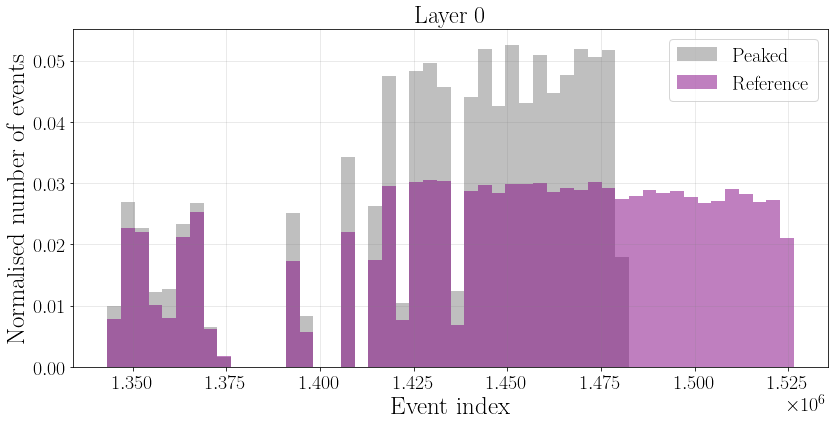

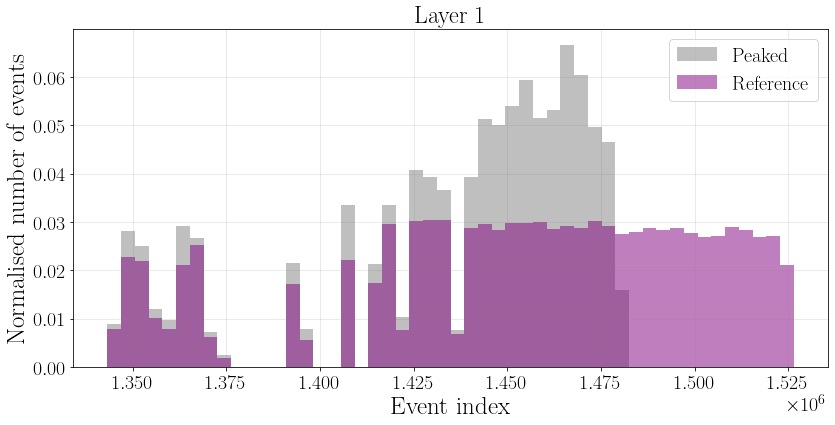

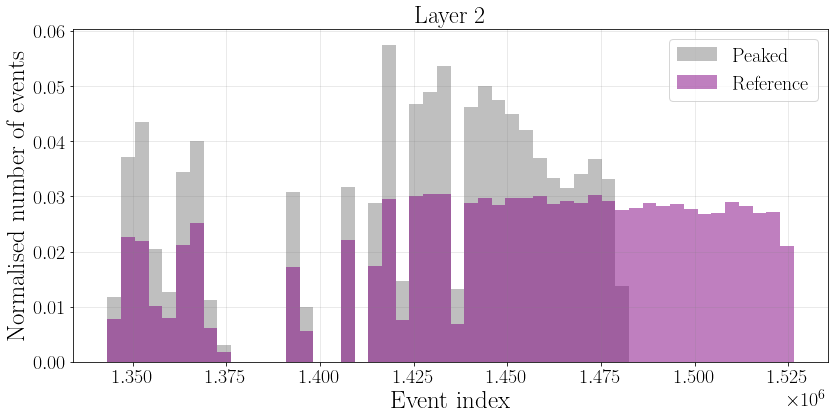

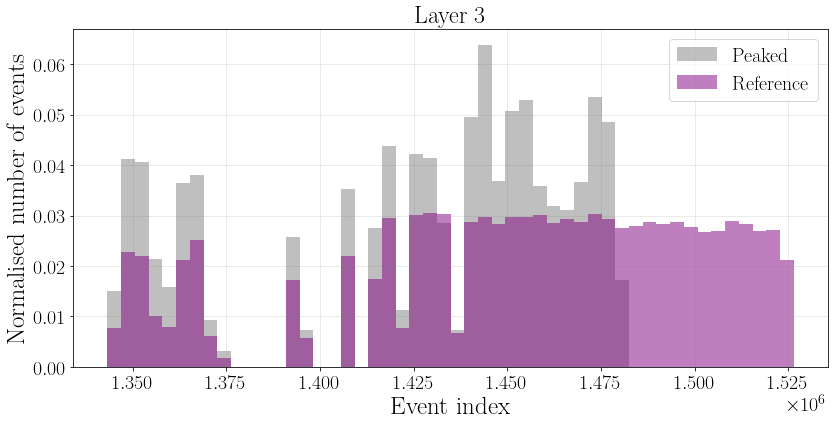

In [56]:
for layer in layers:
    fig, ax = lp.multi_plot_hist_same_col(
        [dataframes[layer], ref_dataframe_layer], 
        "IEvent",
        column_label="Event index",
        list_labels=["Peaked", "Reference"],
        alpha=0.5,
        normalise=True,
        method="one_ax",
        list_colors=list(dict_color_clu_labels.values()),
        #['r', 'g', 'darkorange', 'purple', 'b', 'y', 'g'],
        bins=bins,
        # with_err=True
        # min_max=(1.355e6, 1.356e6)
        # min_max=(1.4565e6, 1.4566e6)
    )
    ax.set_title(f"Layer {layer}")